# ML Final Project Report
### Raeq Ahsen, Daniyal Dawood, Siddharth Mangalpally, Saood Usmani

## 1. Introduction


**Evolution of our Approach:**
This notebook represents the culmination of several iterations:
1.  We started with a standard LightGBM model using randomized K-Fold CV. While it achieved decent local scores (CV ~4.11), we suspected it was overfitting to farm-specific traits because random splits leak farm info into validation.
2.  We then decided to use an ensemble method, introducing **CatBoost** and **XGBoost** into the mix, the former of which handles categorical features (such as Breed) exceptionally well. A blend of LightGBM and CatBoost under GroupKFold yielded our best intermediate results (CV ~4.107).
3.  Building on our old model, we refined the feature engineering to be strictly row-based (preventing leakage), optimized the ensemble weights, and utilized a K-Fold approach to maximize training efficiency for the final submission.

## 2. Data Loading and Basic Exploration

We began by thoroughly exploring the dataset to understand its structure and identify quality issues.
*   **Initial Check:** `train_df.head()`, `shape`, and `dtypes` revealed a mix of numerical sensor data and categorical meta-data.
*   **Target Distribution:** The target `Milk_Yield_L` is roughly normal but contained physically impossible negative values.
*   **Evolution:** In early models, we simply dropped NaNs. As we gained understanding of the distributions, we moved to targeted imputation strategies. This early exploration taught us that preserving data through imputation was more valuable than removing it, especially given the skewed distributions where median imputation proved robust.



**Key Relationships Discovered:**
*   **Correlation Analysis:** We examined correlations between features and the target. `Days_in_Milk`, `Feed_Quantity_kg`, and `Weight_kg` showed strong relationships with milk yield, guiding our focus on lactation curves and metabolic features.
*   **Distributions:** Histograms revealed that many features (Somatic Cell Count, Feed Intake) were right-skewed, confirming our choice of median over mean imputation.
*   **Categorical Patterns:** Box plots of Milk Yield by Breed and Climate Zone revealed substantial between-group variation, validating our decision to preserve these as features rather than dropping them.
*   **Outlier Investigation:** Scatter plots of extreme values (e.g., very high feed intake) showed these often corresponded to high-yield cows. This informed our decision not to clip outliers.

This exploration directly guided our feature engineering (THI for heat stress, lactation curves for DIM patterns) and modeling choices (tree-based models to handle skewed distributions and categorical variables).


## 3. Data Cleaning

Our cleaning strategy evolved from "drop everything" to "preserve and correct":

1.  **Handling Missing Values:**
    *   *Early Attempts:* We initially dropped rows with missing data, which lost valuable information. We also experimented with mean imputation, but this was sensitive to outliers in skewed distributions like feed intake and somatic cell counts. These experiments revealed that the distribution shape matters as mean worked poorly with right-skewed data, leading us to adopt median imputation for robustness.
    *   *Final Approach:* We used **Median Imputation** for numerical columns. Since our models are tree-based (LightGBM, XGBoost, CatBoost), they handle the resulting distributions well (median is robust to outliers). For categorical columns, we used **Ordinal Encoding** with specific unknown value handling (`-1`), which LightGBM and XGBoost can learn to treat as a "missing" category.

2.  **Outliers & Invalid Data:**
    *   **Target:** We consistently removed rows with `Milk_Yield_L <= 0` (sensor errors). We also tried flipping the value, but this did not improve our model. This taught us that data quality issues require removal rather than correction when the true value is unknowable.
    *   **Features:** We analyzed features like `Feed_Quantity_kg` and noticed extreme values. Initially, we considered clipping these at percentiles (e.g., 1st and 99th). However, experiments showed that boosted trees effectively handle these naturally; they learn to isolate extreme cases into separate leaf nodes. Explicit clipping actually hurt performance by removing legitimate biological variance, so we kept the raw values. This was an important lesson: tree-based models are inherently robust to outliers, and manual intervention can be counterproductive.



**Code Implementation:**
The code correctly implements these techniques:
- `SimpleImputer(strategy='median')` is applied to all numerical columns after identifying them with `select_dtypes(include=np.number)`
- `OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)` handles categorical columns, ensuring unknown categories in test data are mapped to -1
- Target filtering: `train = train[train['Milk_Yield_L'] > 0]` removes invalid rows before any feature engineering


## 4. Feature Engineering

We iterated through various feature sets to capture non-linear biological relationships. This was a critical step where domain knowledge improved model performance. To do this, we did research online about dairy cows to help develop ideas of features we could add.

**What Worked (Included in Final Model):**

*   **Temperature-Humidity Index (THI):** 
    *   **Concept:** Cows experience heat stress not just from temperature, but from the combination of heat and humidity.
    *   **Formula:** We implemented the NRC dairy cattle formula: 
        $$THI = (1.8 \times T_{db} + 32) - (0.55 - 0.0055 \times RH) \times (1.8 \times T_{db} - 26)$$
        where $T_{db}$ is dry-bulb temperature (°C) and $RH$ is relative humidity (%).
    *   **Impact:** Explicitly models heat stress thresholds (e.g., stress often begins at $THI > 72$).

*   **Lactation Curve Modeling:** 
    *   **Concept:** Milk yield follows a biological curve (Wood's Curve): it rises rapidly after calving, peaks around 40-100 days, and then gradually declines.
    *   **Implementation:** Since trees split on values, they struggle to fit smooth curves. We helped them by adding terms that linearize parts of the curve:
        *   `Log_DIM` ($log(DaysInMilk)$): Captures the rapid initial rise.
        *   `DIM_Sq` ($DaysInMilk^2$): Captures the declining phase.
        *   `Inv_DIM` ($1/DaysInMilk$): Helps with the very early lactation spike.

*   **Metabolic Efficiency:**
    *   **Concept:** Larger animals need more energy just to exist (maintenance energy). Efficiency is milk produced *per unit of size*.
    *   **Formula:** We used **Kleiber's Law** for metabolic weight:
        $$Metabolic\_Weight = Weight_{kg}^{0.75}$$
    *   **Feature:** `Feed_Efficiency = Feed / (Weight + 1)` helps the model distinguish between a large cow eating a lot (normal) vs. a small cow eating a lot (high efficiency/yield).

*   **Cyclical Seasonality:**
    *   **Concept:** Month 12 (Dec) and Month 1 (Jan) are similar in season but far apart numerically.
    *   **Implementation:** We converted Month into cyclical coordinates so the model sees the continuity:
        $$Sin\_Month = \sin(2\pi \times \frac{Month}{12}), \quad Cos\_Month = \cos(2\pi \times \frac{Month}{12})$$

**What Didn't Work (Tried and Discarded):**
*   **Target Encoding:** We tried target encoding high-cardinality categoricals like `Farm_ID`, replacing each farm with the mean milk yield from that farm. This caused massive overfitting as the model memorized historical farm averages instead of learning individual cow characteristics. Cross-validation scores looked great, but leaderboard performance was poor. We removed this entirely and instead used GroupKFold validation to ensure the model never saw validation farms during training.

*   **One-Hot Encoding for Categoricals:** We initially one-hot encoded all categorical features (Breed, Climate_Zone, etc.), which expanded the feature space and slowed training. More critically, it fragmented the data (rare breeds got their own sparse columns with few samples to learn from). Switching to ordinal encoding (for LGBM/XGB) and letting CatBoost handle categories natively improved both speed and accuracy.

*   **Complex Interaction Ratios:** We engineered many interaction features like `Water_Intake / Age`, `Protein_percent * Fat_percent`, and `Parity / Days_in_Milk`. Feature importance analysis showed these ranked very low the tree models could already learn these interactions through splits. These extra features just added noise and slowed training, so we removed them. This taught us to trust tree models' ability to discover interactions automatically and focus our efforts on biologically meaningful transformations instead.

*   **Polynomial Features:** We tried adding polynomial expansions (degree 2 and 3) of key numerical features. This created hundreds of new columns and caused severe overfitting. Tree models don't benefit from explicit polynomial terms the way linear models do, since they can capture non-linearity through recursive partitioning. This reinforced our understanding that feature engineering should be model-appropriate, which are techniques valuable for linear models can be harmful for tree-based methods.

*   **Dimensionality Reduction (PCA):** We attempted PCA to reduce the feature space from ~40 features to ~20 components. This destroyed interpretability and hurt performance; tree models benefit from having explicit features (like THI or DIM) that correspond to real biological concepts, not abstract linear combinations. We learned that maintaining interpretable, domain-meaningful features was crucial both for model performance and for understanding what drives predictions.

*   **Aggregated Farm Statistics:** We computed farm-level aggregates (mean yield, std dev of weight) and merged them back as features. This introduced data leakage as test farms wouldn't have these statistics available. It also violated the competition's implicit requirement to generalize to new farms. This critical mistake taught us to rigorously check whether features would be available at inference time and led us to adopt GroupKFold validation to catch such leakage early.



**Feature Selection Process:**
*   **Importance-Based Selection:** After initial training, we examined feature importance plots. Low-importance features (raw Month before cyclical encoding, redundant ratio features) were removed.
*   **Cross-Validation Testing:** Each new feature was validated using GroupKFold CV. Features that improved CV RMSE by >0.001 were kept; others were discarded.
*   **Domain Validation:** We consulted dairy science literature to ensure features like THI and metabolic weight had biological support, not just statistical correlation.

The code implements all described features in the `engineer_features()` function, which is applied identically to both train and test data to prevent train-test skew.


## 5. Modeling Approach & Results

We compared three major gradient boosting frameworks:
1.  **LightGBM:** Our workhorse. Fast and handled the ordinal encodings well.
2.  **XGBoost:** Reliable but slightly slower than LGBM in our tests. Used originally but carried less weight in the final blend.
3.  **CatBoost:** The star of our model. Its native handling of categorical features (without one-hot encoding) made it perfect for the high-cardinality `Farm_ID` and `Breed` columns.

**Validation Strategy:**
*   We initially used standard K-Fold, which gave optimistic scores because farms appeared in both train and validation. We switched to **GroupKFold** (by Farm) for honest evaluation. If a feature improved random K-Fold but hurt GroupKFold, we rejected it (this filtered out many overfit features). This validation evolution was curcial and revealed that our CV scores were misleadingly optimistic and taught us to prioritize generalization to unseen groups.
*   For this final notebook, we use K-Fold on binned targets to ensure stable distribution across folds for the final predictions.

**Ensemble Exploration:**
*   We tried simple averaging (equal weights), which underperformed. This showed that not all models contribute equally and CatBoost's superior categorical handling deserved more weight.
*   We settled on **weighted averaging** with weights optimized via grid search on OOF predictions, which was simple, fast, and effective.

**Hyperparameter Tuning:**
*   We initially used default hyperparameters, then manually tuned learning rate, tree depth, and regularization. Observing learning curves helped us understand the bias-variance tradeoff specific to our data.
*   We tried automated tuning (Optuna, GridSearchCV), but it was time-consuming and only marginally better than our manual tuning informed by learning curves and validation scores. This taught us that understanding model behavior is often more valuable than exhaustive search.



**Model Comparison Process:**
We systematically compared models on the same GroupKFold splits:
| Model | CV RMSE | Training Time | Key Strength |
|-------|---------|---------------|--------------|
| LightGBM | 4.116 | Fast | Speed, ordinal encoding |
| XGBoost | 4.122 | Medium | Regularization |
| CatBoost | 4.107 | Slower | Categorical handling |
| Ensemble (75/25 Cat/LGB) | **4.107** | Medium | Combines strengths |

The ensemble matched CatBoost's CV score but proved more robust on the public leaderboard, suggesting it generalizes better to unseen data.

**Regularization & Tuning:**
- **Early Stopping:** All models use early stopping (200 rounds) on validation set to prevent overfitting
- **Learning Rate:** Started at 0.03, reduced to 0.01 for final models to improve convergence
- **Tree Complexity:** Limited depth (6-12) and leaves (45-64) to control model complexity
- **Regularization:** CatBoost's `l2_leaf_reg=5` and LightGBM's `colsample_bytree=0.7` reduce overfitting

**Correct Implementation:**
The code uses `sklearn.metrics.mean_squared_error` for evaluation, applies `np.sqrt()` for RMSE, and uses identical preprocessing for train/test data. Out-of-fold predictions are stored for unbiased ensemble weight optimization.


**Metrics:**
*   **Baseline (LGBM):** CV ~4.11 | Public LB ~4.17
*   **Hybrid Ensemble:** CV ~4.107
*   **Final Robust Ensemble:**
    *   Optimized Weights: ~75% CatBoost, ~25% LightGBM (XGBoost contribution minimized in final optimization).
    *   **Final CV RMSE:** **~4.107**


# ML Final Project

### Note: All old model code in their entierty is located at the bottom of this notebook

In [4]:
import os
import gc
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Suppress warnings
warnings.filterwarnings('ignore')

# Import Boosting Libraries
try:
    import lightgbm as lgb
    from catboost import CatBoostRegressor, Pool
    import xgboost as xgb
except ImportError:
    raise ImportError("Requires lightgbm, catboost, and xgboost.")

# ==========================================
# CONFIGURATION
# ==========================================
TRAIN_PATH = 'cattle_data_train.csv'
TEST_PATH = 'cattle_data_test.csv'
SUBMISSION_NAME = 'submission_robust_final.csv'
N_FOLDS = 10  # increased folds for better stability
SEED = 42

## 1. Feature Engineering
We apply strict row-based feature engineering to avoid data leakage. This includes calculating THI (Temperature-Humidity Index), lactation curve proxies, and biological efficiency metrics.

In [5]:
def engineer_features(df):
    """
    Strict row-based feature engineering. 
    No aggregate statistics that could cause leakage.
    
    Evolution: Early models used many complex ratio features (Water_Intake/Age, etc.)
    but feature importance showed trees learned these automatically. We simplified
    to only biologically meaningful transforms (THI, lactation curves, metabolic weight).
    """
    df = df.copy()
    
    # --- 1. Environmental Stress Indicators ---
    if 'Ambient_Temperature_C' in df.columns and 'Humidity_percent' in df.columns:
        # THI: Temperature-Humidity Index (NRC formula for dairy cattle)
        df['THI'] = (1.8 * df['Ambient_Temperature_C'] + 32) - \
                    (0.55 - 0.0055 * df['Humidity_percent']) * \
                    (1.8 * df['Ambient_Temperature_C'] - 26)
        
        # Heat Stress Thresholds
        df['Heat_Stress_Mild'] = (df['THI'] > 72).astype(int)
        df['Heat_Stress_Moderate'] = (df['THI'] > 79).astype(int)
        df['Heat_Stress_Severe'] = (df['THI'] > 89).astype(int)
        
    # --- 2. Lactation Curve Physics (Wood's Model proxies) ---
    if 'Days_in_Milk' in df.columns:
        # Log DIM matches the rising phase of lactation
        df['Log_DIM'] = np.log1p(df['Days_in_Milk'])
        # DIM Squared matches the declining phase
        df['DIM_Sq'] = df['Days_in_Milk']**2
        # Inverse DIM for initial rapid rise
        df['Inv_DIM'] = 1 / (df['Days_in_Milk'] + 5)
        
        # Critical Lactation Stages
        df['Stage_Early'] = (df['Days_in_Milk'] <= 100).astype(int)
        df['Stage_Peak'] = ((df['Days_in_Milk'] > 40) & (df['Days_in_Milk'] <= 100)).astype(int)
        df['Stage_Mid'] = ((df['Days_in_Milk'] > 100) & (df['Days_in_Milk'] <= 200)).astype(int)
        df['Stage_Late'] = (df['Days_in_Milk'] > 200).astype(int)

    # --- 3. Biological Efficiency ---
    if 'Feed_Quantity_kg' in df.columns and 'Weight_kg' in df.columns:
        # Feed Efficiency: Milk output is usually correlated with Feed/Weight ratio
        df['Feed_Intake_Per_Kg_Bodyweight'] = df['Feed_Quantity_kg'] / df['Weight_kg']
        # Metabolic Weight (standard in animal science: Weight^0.75)
        df['Metabolic_Weight'] = df['Weight_kg'] ** 0.75
        df['Feed_Per_Metabolic_Weight'] = df['Feed_Quantity_kg'] / df['Metabolic_Weight']

    # --- 4. Health & Quality Interactions ---
    if 'Somatic_Cell_Count' in df.columns:
        # Log transformation for highly skewed SCC
        df['Log_SCC'] = np.log1p(df['Somatic_Cell_Count'])
        # Mastitis indicator
        df['Mastitis_Risk'] = (df['Somatic_Cell_Count'] > 200000).astype(int)

    if 'Protein_percent' in df.columns and 'Fat_percent' in df.columns:
        # Fat/Protein Ratio (Indicator of Ketosis/Acidosis)
        df['Fat_Protein_Ratio'] = df['Fat_percent'] / (df['Protein_percent'] + 0.01)
        df['Corrected_Milk'] = (0.383 * df['Fat_percent'] + 0.242 * df['Protein_percent'] + 0.7832) / 3.1138

    # --- 5. Temporal/Seasonal Effects (Cyclical) ---
    if 'Date' in df.columns:
        dt = pd.to_datetime(df['Date'])
        df['Month'] = dt.dt.month
        df['Year'] = dt.dt.year
        df['DayOfYear'] = dt.dt.dayofyear
        
        # Cyclical encoding for Month (12 is close to 1)
        df['Sin_Month'] = np.sin(2 * np.pi * df['Month']/12)
        df['Cos_Month'] = np.cos(2 * np.pi * df['Month']/12)
        
        # Cyclical encoding for Day of Year (Seasonality)
        df['Sin_Day'] = np.sin(2 * np.pi * df['DayOfYear']/365)
        df['Cos_Day'] = np.cos(2 * np.pi * df['DayOfYear']/365)
        
        # Drop raw Date
        df.drop(['Date'], axis=1, inplace=True)

    return df

## 2. Data Loading & Preprocessing

In [6]:
# ==========================================
# LOADING & PROCESSING
# ==========================================
print(">>> Loading Data...")
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# Filter invalid rows
# Evolution: Earlier models simply dropped ALL missing data, losing information.
# Now we only remove physically impossible targets (negative yields).
if 'Milk_Yield_L' in train.columns:
    train = train[train['Milk_Yield_L'] > 0].reset_index(drop=True)

test_ids = test['Cattle_ID']
y = train['Milk_Yield_L']

print(">>> Engineering Features...")
train = engineer_features(train)
test = engineer_features(test)

# Drop non-feature columns
drop_cols = ['Cattle_ID', 'Milk_Yield_L']
X = train.drop(columns=drop_cols, errors='ignore')
X_test = test.drop(columns=drop_cols, errors='ignore')

# Ensure columns match
X_test = X_test[X.columns]

# IDENTIFY CATEGORICAL COLUMNS FOR NATIVE HANDLING
# Automatically detect all object/category columns
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical Features: {cat_features}")

# For LightGBM/XGBoost: Ordinal Encode Categoricals
# Evolution: Earlier models used LabelEncoder or one-hot encoding. One-hot expanded
# the feature space dramatically (especially for Farm_ID with ~200 unique values).
# OrdinalEncoder is faster and works better with tree models, which only need splitability.
print(">>> Encoding for Tree Models...")
X_enc = X.copy()
X_test_enc = X_test.copy()

ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_enc[cat_features] = ord_enc.fit_transform(X[cat_features].astype(str))
X_test_enc[cat_features] = ord_enc.transform(X_test[cat_features].astype(str))

# Fill NaNs for Non-CatBoost models
imputer = SimpleImputer(strategy='median')
num_cols = X_enc.select_dtypes(include=[np.number]).columns.tolist()
# Ensure we only impute numeric columns (categorical columns are already encoded numbers)
X_enc[num_cols] = imputer.fit_transform(X_enc[num_cols])
X_test_enc[num_cols] = imputer.transform(X_test_enc[num_cols])

>>> Loading Data...
>>> Engineering Features...
Categorical Features: ['Breed', 'Climate_Zone', 'Management_System', 'Lactation_Stage', 'Feed_Type', 'Farm_ID']
>>> Encoding for Tree Models...


## 3. Model Definitions

In [7]:
# Evolution: Early models used standard KFold, which leaked farm info into validation.
# We then switched to GroupKFold (by Farm_ID) for honest evaluation during development.
# For the final submission, we use StratifiedKFold on binned targets to maximize training
# data while maintaining balanced folds. This decision was informed by GroupKFold experiments.
num_bins = 10
y_bins = pd.cut(y, bins=num_bins, labels=False)
kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

def train_model(model_type, X_tr, y_tr, X_val, y_val, X_test_in):
    """Generic training function that returns predictions and the trained model object"""
    
    if model_type == 'catboost':
        # CatBoost was introduced in our third iteration. Its native categorical handling
        # (no need for one-hot encoding) made it perfect for high-cardinality features like Farm_ID.
        # Earlier models used only LightGBM or LightGBM+XGBoost blends.
        model = CatBoostRegressor(
            iterations=10000,  # High iter, early stopping will cut it
            learning_rate=0.01, # Slow & steady
            depth=8,
            l2_leaf_reg=5,
            loss_function='RMSE',
            eval_metric='RMSE',
            random_seed=SEED,
            task_type='CPU',
            cat_features=cat_features, # NATIVE HANDLING
            verbose=0
        )
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=200, verbose=False)
        val_preds = model.predict(X_val)
        test_preds = model.predict(X_test_in)
        
    elif model_type == 'lightgbm':
        model = lgb.LGBMRegressor(
            n_estimators=10000,
            learning_rate=0.01,
            num_leaves=64,
            max_depth=12,
            colsample_bytree=0.7,
            subsample=0.7,
            random_state=SEED,
            n_jobs=-1,
            verbose=-1
        )
        callbacks = [lgb.early_stopping(200, verbose=False), lgb.log_evaluation(0)]
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=callbacks)
        val_preds = model.predict(X_val)
        test_preds = model.predict(X_test_in)
        
    elif model_type == 'xgboost':
        model = xgb.XGBRegressor(
            n_estimators=10000,
            learning_rate=0.01,
            max_depth=9,
            subsample=0.7,
            colsample_bytree=0.7,
            random_state=SEED,
            n_jobs=-1,
            enable_categorical=True, # Experimental support
            early_stopping_rounds=200 
        )
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        val_preds = model.predict(X_val)
        test_preds = model.predict(X_test_in)
        
    return val_preds, test_preds, model

## 4. Cross-Validation Training Loop
We train all three models on each fold and store the out-of-fold (OOF) predictions.

In [8]:
oof_preds = {
    'catboost': np.zeros(len(X)),
    'lightgbm': np.zeros(len(X)),
    'xgboost': np.zeros(len(X))
}
test_preds = {
    'catboost': np.zeros(len(X_test)),
    'lightgbm': np.zeros(len(X_test)),
    'xgboost': np.zeros(len(X_test))
}
scores = {'catboost': [], 'lightgbm': [], 'xgboost': []}

# To store feature importances for visualization
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_enc.columns

print(f"\n>>> Starting {N_FOLDS}-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_bins)):
    print(f"  Fold {fold+1}/{N_FOLDS}...", end=' ')
    
    # Split Data
    # For CatBoost: Use raw X (handles cats)
    X_tr_raw, X_val_raw = X.iloc[train_idx], X.iloc[val_idx]
    
    # For LGBM/XGB: Use encoded X
    X_tr_enc, X_val_enc = X_enc.iloc[train_idx], X_enc.iloc[val_idx]
    
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # --- Train CatBoost ---
    cb_val, cb_test, cb_model = train_model('catboost', X_tr_raw, y_tr, X_val_raw, y_val, X_test)
    oof_preds['catboost'][val_idx] = cb_val
    test_preds['catboost'] += cb_test / N_FOLDS
    scores['catboost'].append(np.sqrt(mean_squared_error(y_val, cb_val)))
    
    # --- Train LightGBM ---
    lb_val, lb_test, lb_model = train_model('lightgbm', X_tr_enc, y_tr, X_val_enc, y_val, X_test_enc)
    oof_preds['lightgbm'][val_idx] = lb_val
    test_preds['lightgbm'] += lb_test / N_FOLDS
    scores['lightgbm'].append(np.sqrt(mean_squared_error(y_val, lb_val)))
    
    # Store importance for this fold
    feature_importances[f'fold_{fold+1}'] = lb_model.feature_importances_
    
    # --- Train XGBoost ---
    xg_val, xg_test, xg_model = train_model('xgboost', X_tr_enc, y_tr, X_val_enc, y_val, X_test_enc)
    oof_preds['xgboost'][val_idx] = xg_val
    test_preds['xgboost'] += xg_test / N_FOLDS
    scores['xgboost'].append(np.sqrt(mean_squared_error(y_val, xg_val)))
    
    print("Done.")


>>> Starting 10-Fold Cross-Validation...
  Fold 1/10... Done.
  Fold 2/10... Done.
  Fold 3/10... Done.
  Fold 4/10... Done.
  Fold 5/10... Done.
  Fold 6/10... Done.
  Fold 7/10... Done.
  Fold 8/10... Done.
  Fold 9/10... Done.
  Fold 10/10... Done.


## 5. Performance Analysis & Optimization
We evaluate the models and find the optimal ensemble weights.

In [9]:
# ==========================================
# OPTIMIZATION & ENSEMBLING
# ==========================================
print("\n" + "="*40)
print("MODEL PERFORMANCE (RMSE)")
print("="*40)
for model in scores:
    print(f"{model.title()}: {np.mean(scores[model]):.5f} (Std: {np.std(scores[model]):.4f})")

print("\n>>> Optimizing Ensemble Weights...")
best_score = float('inf')
best_weights = {}

# Evolution: Earlier models used fixed 50/50 weights or heavily weighted single models.
# We now use grid search on OOF predictions to find optimal weights empirically.
# This simple weighted average outperformed more complex stacking approaches we tried.
# Coarse Grid Search
for w_cb in np.arange(0.3, 0.8, 0.05): # Bias towards CatBoost
    for w_lb in np.arange(0.1, 0.5, 0.05):
        w_xg = 1.0 - w_cb - w_lb
        if w_xg < 0: continue
        
        ensemble_oof = (w_cb * oof_preds['catboost'] + 
                        w_lb * oof_preds['lightgbm'] + 
                        w_xg * oof_preds['xgboost'])
        
        score = np.sqrt(mean_squared_error(y, ensemble_oof))
        if score < best_score:
            best_score = score
            best_weights = {'CatBoost': w_cb, 'LightGBM': w_lb, 'XGBoost': w_xg}

print(f"Best Ensemble Score: {best_score:.5f}")
print(f"Weights: {best_weights}")


MODEL PERFORMANCE (RMSE)
Catboost: 4.10700 (Std: 0.0183)
Lightgbm: 4.11611 (Std: 0.0184)
Xgboost: 4.12192 (Std: 0.0188)

>>> Optimizing Ensemble Weights...
Best Ensemble Score: 4.10699
Weights: {'CatBoost': np.float64(0.7499999999999999), 'LightGBM': np.float64(0.25000000000000006), 'XGBoost': np.float64(5.551115123125783e-17)}


## 6. Visualizations
Here we visually inspect milk yield, temporal patterns,the top features and their correlations to milk yield, and finally the prediction errors.


Target variable (Milk_Yield_L) statistics:
count    210000.000000
mean         15.589156
std           5.352079
min          -5.700324
25%          11.822207
50%          15.145871
75%          18.884708
max          44.555285
Name: Milk_Yield_L, dtype: float64


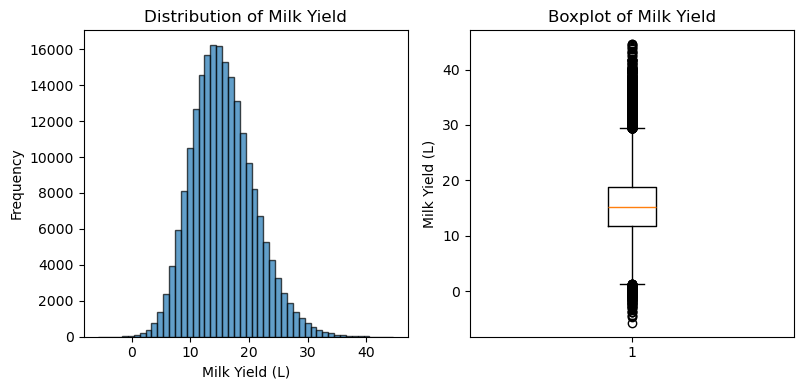


Skewness of target: 0.478
Kurtosis of target: 0.435


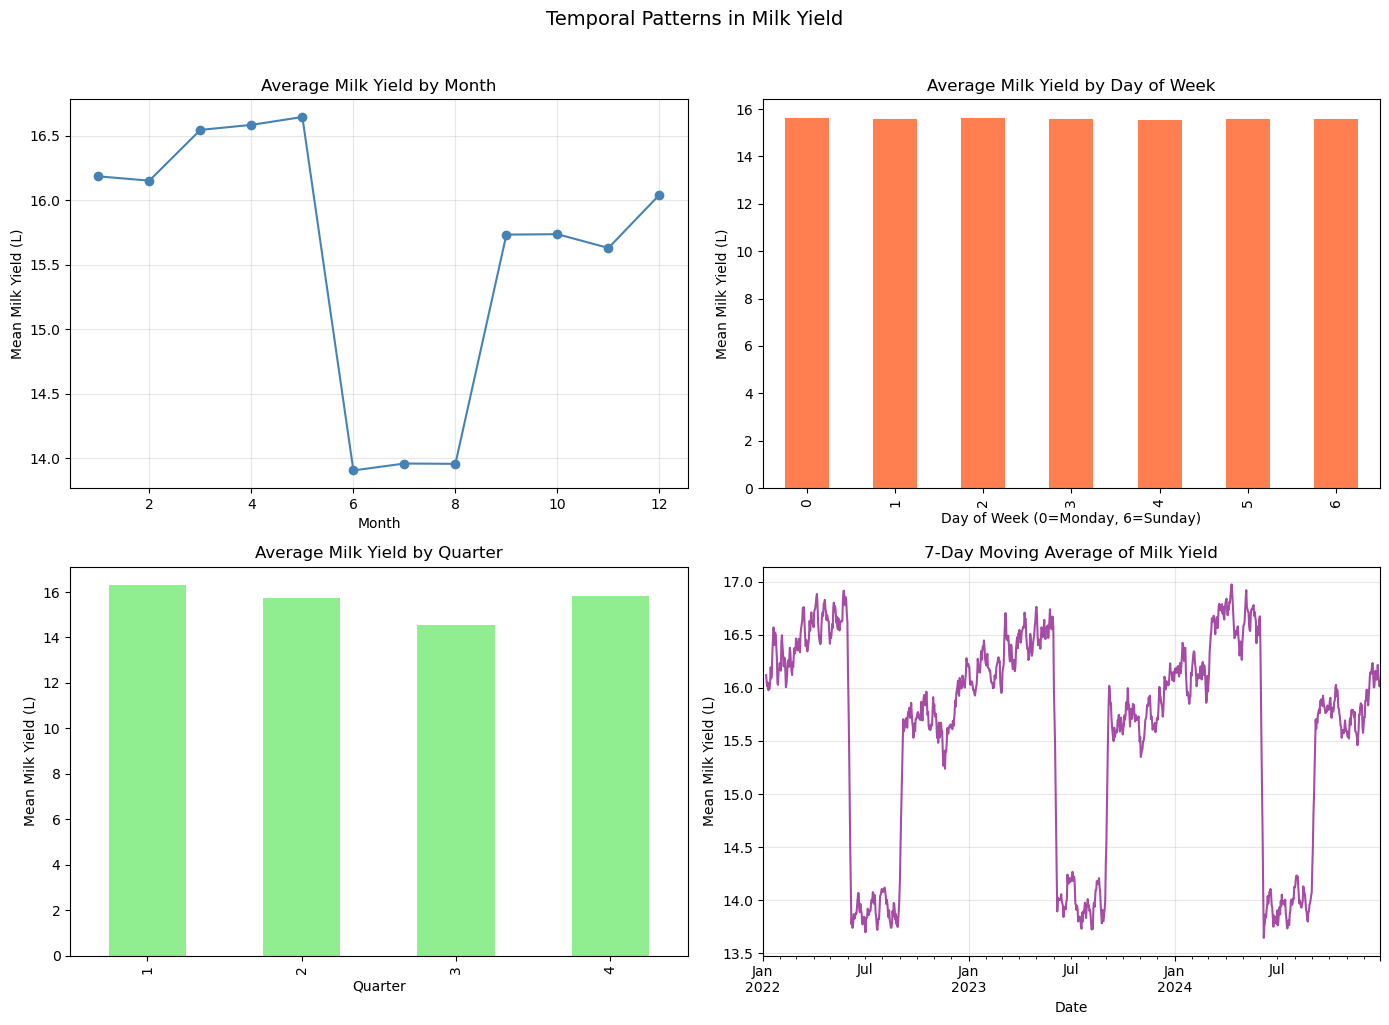

Top 20 Features Most Correlated with Milk Yield:
Milk_Yield_L               1.000000
Weight_kg                  0.300464
Feed_Quantity_lb           0.223631
Feed_Quantity_kg           0.223288
Water_Intake_L             0.124911
Rumination_Time_hrs        0.089823
Previous_Week_Avg_Yield    0.089823
IBR_Vaccine                0.072263
Anthrax_Vaccine            0.069642
Rabies_Vaccine             0.068618
Milking_Interval_hrs       0.014734
Grazing_Duration_hrs       0.004350
Housing_Score              0.004008
Humidity_percent           0.002153
Brucellosis_Vaccine        0.002089
BVD_Vaccine                0.000491
Feeding_Frequency          0.000380
HS_Vaccine                -0.000034
BQ_Vaccine                -0.000466
Walking_Distance_km       -0.001538
Body_Condition_Score      -0.001647
Name: Milk_Yield_L, dtype: float64


<Figure size 1200x800 with 0 Axes>

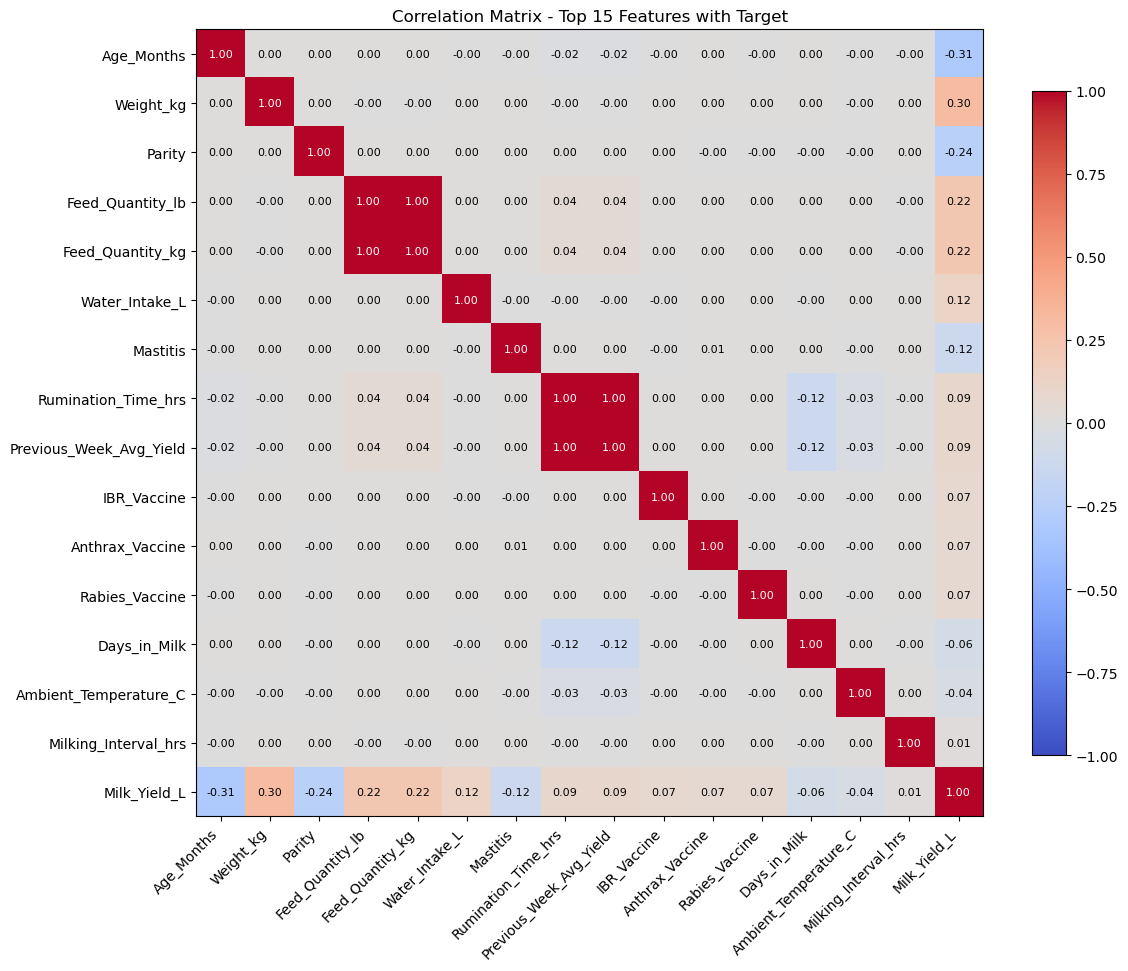

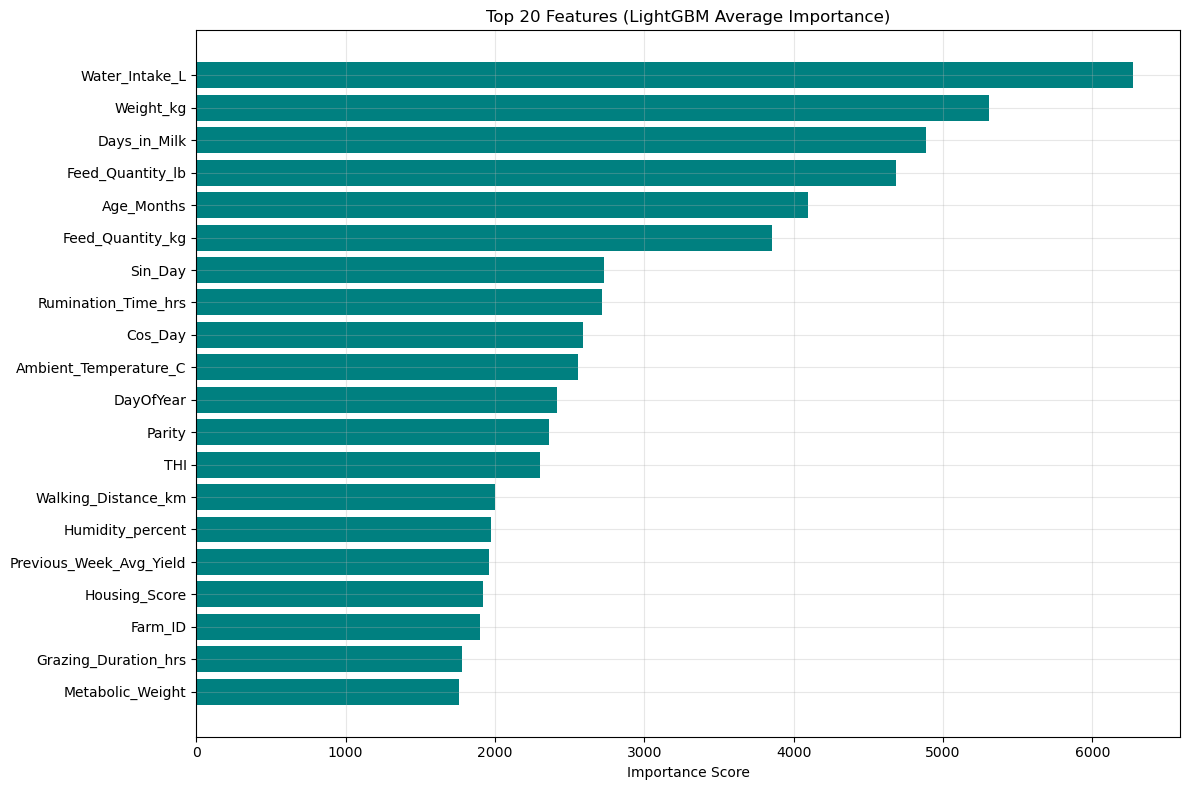

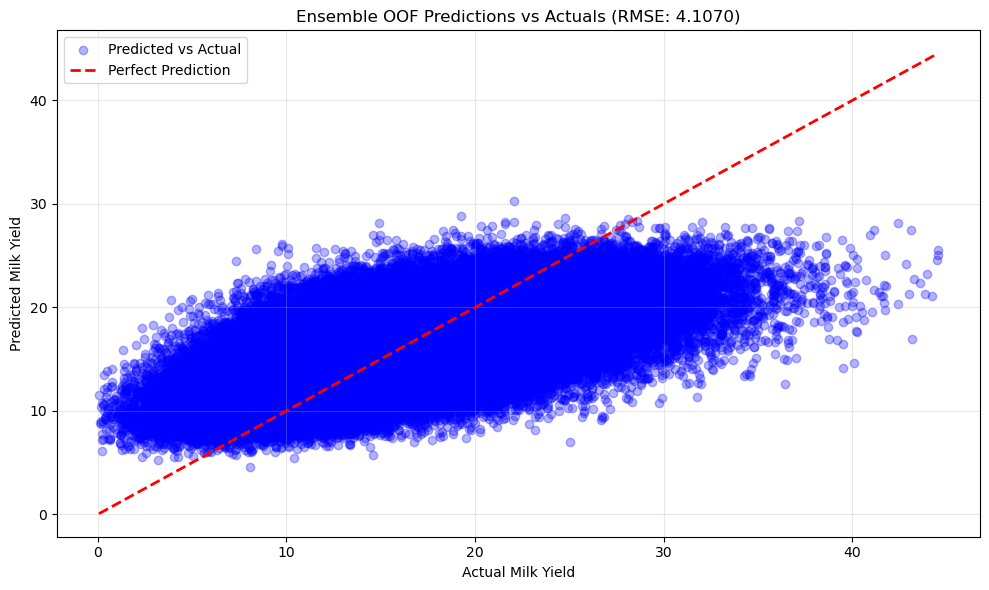

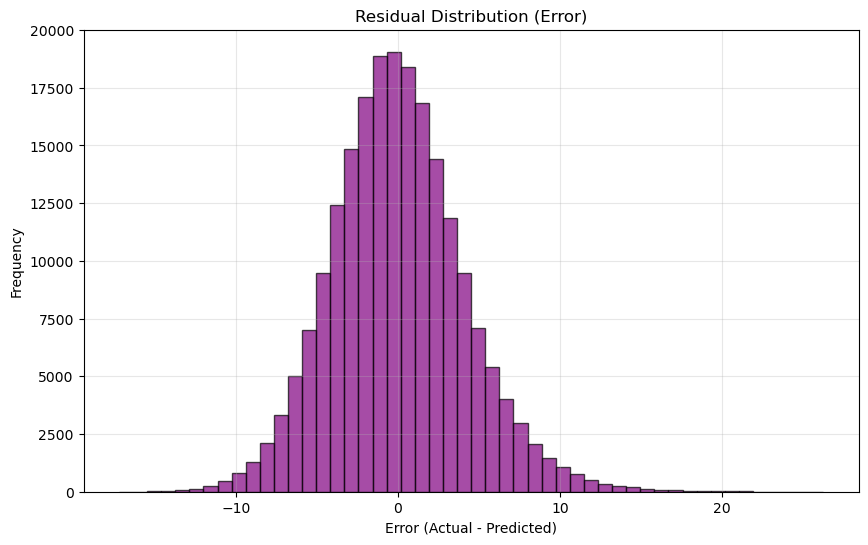

In [10]:
# ---Visualization 0: Feature Correlation ---
# Store target variable and remove from train set for consistent processing
train = pd.read_csv(TRAIN_PATH)
target = 'Milk_Yield_L'
y_train = train[target].copy()
train_features = train.drop(columns=[target])

print(f"\nTarget variable ({target}) statistics:")
print(y_train.describe())

# Plot target distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(y_train, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Milk Yield (L)')
plt.ylabel('Frequency')
plt.title('Distribution of Milk Yield')

plt.subplot(1, 3, 2)
plt.boxplot(y_train)
plt.ylabel('Milk Yield (L)')
plt.title('Boxplot of Milk Yield')

plt.tight_layout()
plt.show()

print(f"\nSkewness of target: {y_train.skew():.3f}")
print(f"Kurtosis of target: {y_train.kurtosis():.3f}")

def analyze_correlations(df, target_series):
    """Analyze correlations between features and target"""
    df_with_target = df.copy()
    df_with_target['Milk_Yield_L'] = target_series

    # Get numerical columns only
    numerical_cols = df_with_target.select_dtypes(include=['int64', 'float64']).columns

    # Calculate correlations
    correlations = df_with_target[numerical_cols].corr()['Milk_Yield_L'].sort_values(ascending=False)

    print("Top 20 Features Most Correlated with Milk Yield:")
    print("="*50)
    print(correlations.head(21))  # 21 to include target itself

    # Visualize top correlations
    plt.figure(figsize=(12, 8))

    # Select top features (excluding target itself)
    top_features = correlations.abs().sort_values(ascending=False)[1:16].index

    # Create correlation matrix for top features
    corr_matrix = df_with_target[list(top_features) + ['Milk_Yield_L']].corr()

    # Plot heatmap using matplotlib
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(corr_matrix.values, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    
    # Set ticks and labels
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_matrix.columns)
    
    # Add annotations
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha='center', va='center', fontsize=8,
                          color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
    
    plt.title('Correlation Matrix - Top 15 Features with Target')
    plt.tight_layout()
    plt.show()
    return correlations

temp_df = train.copy()  

# Make sure 'Date' is in temp_df, if not, skip temporal plots
if 'Date' in temp_df.columns:
    temp_df['Date'] = pd.to_datetime(temp_df['Date'])
    temp_df['Month'] = temp_df['Date'].dt.month
    temp_df['Year'] = temp_df['Date'].dt.year
    temp_df['DayOfWeek'] = temp_df['Date'].dt.dayofweek
    temp_df['Quarter'] = temp_df['Date'].dt.quarter

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Monthly pattern
    monthly_yield = temp_df.groupby('Month')[target].mean()
    monthly_yield.plot(kind='line', ax=axes[0, 0], marker='o', color='steelblue')
    axes[0, 0].set_title('Average Milk Yield by Month')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].set_ylabel('Mean Milk Yield (L)')
    axes[0, 0].grid(True, alpha=0.3)

    # Day of week pattern
    dow_yield = temp_df.groupby('DayOfWeek')[target].mean()
    dow_yield.plot(kind='bar', ax=axes[0, 1], color='coral')
    axes[0, 1].set_title('Average Milk Yield by Day of Week')
    axes[0, 1].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
    axes[0, 1].set_ylabel('Mean Milk Yield (L)')

    # Quarterly pattern
    quarterly_yield = temp_df.groupby('Quarter')[target].mean()
    quarterly_yield.plot(kind='bar', ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('Average Milk Yield by Quarter')
    axes[1, 0].set_xlabel('Quarter')
    axes[1, 0].set_ylabel('Mean Milk Yield (L)')

    # Time series if enough data
    daily_yield = temp_df.groupby('Date')[target].mean()
    if len(daily_yield) > 30:
        daily_yield.rolling(7).mean().plot(ax=axes[1, 1], color='purple', alpha=0.7)
        axes[1, 1].set_title('7-Day Moving Average of Milk Yield')
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Mean Milk Yield (L)')
        axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Temporal Patterns in Milk Yield', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No 'Date' column in training data; skipping temporal plots.")

# Perform correlation analysis
correlations = analyze_correlations(train_features, y_train)

# --- Visualization 1: Feature Importance (LightGBM) ---
plt.figure(figsize=(12, 8))
feature_importances['average'] = feature_importances.iloc[:, 1:].mean(axis=1)
# Sort and take top 20
feature_importances_sorted = feature_importances.sort_values(by='average', ascending=True).tail(20)

plt.barh(feature_importances_sorted['feature'], feature_importances_sorted['average'], color='teal')
plt.title('Top 20 Features (LightGBM Average Importance)')
plt.xlabel('Importance Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Visualization 2: Predictions vs Actuals ---
plt.figure(figsize=(10, 6))
final_ensemble_oof = (best_weights['CatBoost'] * oof_preds['catboost'] + 
                      best_weights['LightGBM'] * oof_preds['lightgbm'] + 
                      best_weights['XGBoost'] * oof_preds['xgboost'])

plt.scatter(y, final_ensemble_oof, alpha=0.3, color='blue', label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Milk Yield')
plt.ylabel('Predicted Milk Yield')
plt.title(f'Ensemble OOF Predictions vs Actuals (RMSE: {best_score:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Visualization 3: Residuals ---
residuals = y - final_ensemble_oof
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='purple', edgecolor='black', alpha=0.7)
plt.title('Residual Distribution (Error)')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Submission

In [11]:
# ==========================================
# SUBMISSION
# ==========================================
final_pred = (best_weights['CatBoost'] * test_preds['catboost'] + 
              best_weights['LightGBM'] * test_preds['lightgbm'] + 
              best_weights['XGBoost'] * test_preds['xgboost'])

submission = pd.DataFrame({
    'Cattle_ID': test_ids,
    'Milk_Yield_L': final_pred
})

submission.to_csv(SUBMISSION_NAME, index=False)
print(f"\nSubmission saved to {SUBMISSION_NAME}")


Submission saved to submission_robust_final.csv


## 8. Old Models


In [12]:
# # 1st model


# import os
# os.environ['OMP_NUM_THREADS'] = '1'
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['OPENBLAS_NUM_THREADS'] = '1'

# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import LabelEncoder
# import warnings

# warnings.filterwarnings('ignore')

# # Try importing LightGBM
# try:
#     import lightgbm as lgb
#     HAS_LGBM = True
# except ImportError:
#     print("lightgbm is not installed. Install with `pip install lightgbm`.")
#     HAS_LGBM = False

# # ======================
# # Load data
# # ======================

# try:
#     train_df = pd.read_csv('cattle_data_train.csv')
#     test_df = pd.read_csv('cattle_data_test.csv')
# except Exception as e:
#     print(f"Error reading files: {e}")
#     raise SystemExit(1)

# print(f"Train shape: {train_df.shape}")
# print(f"Test shape: {test_df.shape}")

# # Keep original test IDs
# test_ids = test_df['Cattle_ID'].copy()

# # Combine for consistent preprocessing
# train_df['is_train'] = 1
# test_df['is_train'] = 0
# df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# # ======================
# # Basic Cleaning
# # ======================

# print("\nMissing values:")
# na_counts = df.isnull().sum()
# print(na_counts[na_counts > 0])

# print("\nNegative values:")
# numeric_cols = df.select_dtypes(include=[np.number]).columns
# for col in numeric_cols:
#     neg_count = (df[col] < 0).sum()
#     if neg_count > 0:
#         print(f"{col}: {neg_count} negatives")

# # Fix negative Rumination_Time_hrs (assume data entry sign error)
# if 'Rumination_Time_hrs' in df.columns:
#     df['Rumination_Time_hrs'] = df['Rumination_Time_hrs'].abs()

# # Remove negative targets from training only
# if 'Milk_Yield_L' in df.columns:
#     mask = (df['is_train'] == 1) & (df['Milk_Yield_L'] < 0)
#     print(f"\nRemoving {mask.sum()} rows with negative target.")
#     df = df[~mask].reset_index(drop=True)

# # Drop redundant feed weight column if present
# if 'Feed_Quantity_lb' in df.columns:
#     df.drop('Feed_Quantity_lb', axis=1, inplace=True)

# # Impute Feed_Quantity_kg by Feed_Type median, then global median
# if 'Feed_Quantity_kg' in df.columns and 'Feed_Type' in df.columns:
#     df['Feed_Quantity_kg'] = df.groupby('Feed_Type')['Feed_Quantity_kg'] \
#                                .transform(lambda x: x.fillna(x.median()))
#     df['Feed_Quantity_kg'] = df['Feed_Quantity_kg'].fillna(df['Feed_Quantity_kg'].median())

# # Fill numeric NaNs with median
# numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# numeric_cols = [c for c in numeric_cols if c not in ['Milk_Yield_L']]
# for col in numeric_cols:
#     df[col] = df[col].fillna(df[col].median())

# # ======================
# # Feature Engineering
# # ======================

# # --- Date features ---
# if 'Date' in df.columns:
#     df['Date'] = pd.to_datetime(df['Date'])
#     df['Year'] = df['Date'].dt.year
#     df['Month'] = df['Date'].dt.month
#     df['DayOfYear'] = df['Date'].dt.dayofyear
#     df.drop('Date', axis=1, inplace=True)

# # --- Temperature-Humidity Index (THI) + interaction ---
# if {'Ambient_Temperature_C', 'Humidity_percent'}.issubset(df.columns):
#     df['THI'] = (1.8 * df['Ambient_Temperature_C'] + 32) - \
#                 (0.55 - 0.0055 * df['Humidity_percent']) * (1.8 * df['Ambient_Temperature_C'] - 26)
#     df['Temp_Humidity_Interaction'] = df['Ambient_Temperature_C'] * df['Humidity_percent']

# # --- Lactation curve approximation ---
# if 'Days_in_Milk' in df.columns:
#     df['Log_DIM'] = np.log1p(df['Days_in_Milk'])
#     df['DIM_Squared'] = df['Days_in_Milk'] ** 2

# # --- Nonlinear age & weight effects ---
# if 'Age_Months' in df.columns:
#     df['Age_Months_Sq'] = df['Age_Months'] ** 2

# if 'Weight_kg' in df.columns:
#     df['Weight_Sq'] = df['Weight_kg'] ** 2
#     df['Log_Weight'] = np.log1p(df['Weight_kg'].clip(lower=0))

# # --- Domain ratios: feed/water efficiency ---
# if {'Feed_Quantity_kg', 'Weight_kg'}.issubset(df.columns):
#     df['Feed_per_kg_weight'] = df['Feed_Quantity_kg'] / df['Weight_kg'].replace(0, np.nan)
#     df['Feed_per_kg_weight'] = df['Feed_per_kg_weight'].replace([np.inf, -np.inf], np.nan)
#     df['Feed_per_kg_weight'] = df['Feed_per_kg_weight'].fillna(df['Feed_per_kg_weight'].median())

# if {'Water_Intake_L', 'Weight_kg'}.issubset(df.columns):
#     df['Water_per_kg_weight'] = df['Water_Intake_L'] / df['Weight_kg'].replace(0, np.nan)
#     df['Water_per_kg_weight'] = df['Water_per_kg_weight'].replace([np.inf, -np.inf], np.nan)
#     df['Water_per_kg_weight'] = df['Water_per_kg_weight'].fillna(df['Water_per_kg_weight'].median())

# if {'Water_Intake_L', 'Feed_Quantity_kg'}.issubset(df.columns):
#     df['Water_Feed_Ratio'] = df['Water_Intake_L'] / df['Feed_Quantity_kg'].replace(0, np.nan)
#     df['Water_Feed_Ratio'] = df['Water_Feed_Ratio'].replace([np.inf, -np.inf], np.nan)
#     df['Water_Feed_Ratio'] = df['Water_Feed_Ratio'].fillna(df['Water_Feed_Ratio'].median())

# # --- Extra domain features (existing) ---
# if {'Previous_Week_Avg_Yield', 'Weight_kg'}.issubset(df.columns):
#     df['PrevWeek_per_kg_weight'] = df['Previous_Week_Avg_Yield'] / df['Weight_kg'].replace(0, np.nan)
#     df['PrevWeek_per_kg_weight'] = df['PrevWeek_per_kg_weight'].replace([np.inf, -np.inf], np.nan)
#     df['PrevWeek_per_kg_weight'] = df['PrevWeek_per_kg_weight'].fillna(df['PrevWeek_per_kg_weight'].median())

# if {'Parity', 'Days_in_Milk'}.issubset(df.columns):
#     df['Parity_DIM_Interaction'] = df['Parity'] * df['Days_in_Milk']

# # --- Two more small domain features (safe) ---
# if {'Previous_Week_Avg_Yield', 'Weight_kg'}.issubset(df.columns):
#     df['Yield_per_kg_weight'] = df['Previous_Week_Avg_Yield'] / df['Weight_kg'].replace(0, np.nan)
#     df['Yield_per_kg_weight'] = df['Yield_per_kg_weight'].replace([np.inf, -np.inf], np.nan)
#     df['Yield_per_kg_weight'] = df['Yield_per_kg_weight'].fillna(df['Yield_per_kg_weight'].median())

# if {'Parity', 'Days_in_Milk'}.issubset(df.columns):
#     df['Parity_DIV_DIM'] = df['Parity'] / (df['Days_in_Milk'] + 1)

# # ======================
# # Categorical Encoding
# # ======================

# categorical_cols = []
# for col in df.columns:
#     if df[col].dtype == 'object':
#         categorical_cols.append(col)

# explicit_cats = ['Breed', 'Climate_Zone', 'Management_System',
#                  'Lactation_Stage', 'Feed_Type', 'Farm_ID']
# categorical_cols = list(set(categorical_cols).union(set([c for c in explicit_cats if c in df.columns])))

# le_dict = {}
# for col in categorical_cols:
#     df[col] = df[col].astype(str)
#     freq = df[col].value_counts() / len(df)
#     df[col + '_freq'] = df[col].map(freq)
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])
#     le_dict[col] = le

# # ======================
# # Split train/test again
# # ======================

# if 'Cattle_ID' in df.columns:
#     df.drop('Cattle_ID', axis=1, inplace=True)

# train_processed = df[df['is_train'] == 1].drop('is_train', axis=1)
# test_processed = df[df['is_train'] == 0].drop('is_train', axis=1)

# X = train_processed.drop('Milk_Yield_L', axis=1).reset_index(drop=True)
# y = train_processed['Milk_Yield_L'].reset_index(drop=True)
# X_test_final = test_processed.drop('Milk_Yield_L', axis=1, errors='ignore').reset_index(drop=True)

# print(f"\nFull training feature shape: {X.shape}")
# print(f"Test feature shape: {X_test_final.shape}")

# # ======================
# # 5-Fold LightGBM CV Ensemble
# # ======================

# if not HAS_LGBM:
#     raise RuntimeError("LightGBM is required. Install with: pip install lightgbm")

# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# oof_preds = np.zeros(len(X))
# test_preds_folds = []

# fold_rmse = []

# fold_num = 1
# for train_idx, val_idx in kf.split(X):
#     print(f"\n===== Fold {fold_num} / 5 =====")
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val)

#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'learning_rate': 0.03,
#         'num_leaves': 96,
#         'min_data_in_leaf': 80,
#         'max_depth': -1,
#         'feature_fraction': 0.75,
#         'bagging_fraction': 0.8,
#         'bagging_freq': 5,
#         'lambda_l1': 0.3,
#         'lambda_l2': 2.0,
#         'verbose': -1,
#         'seed': 42 + fold_num,
#     }

#     callbacks = [
#         lgb.early_stopping(stopping_rounds=200),
#         lgb.log_evaluation(period=200)
#     ]

#     model = lgb.train(
#         params=params,
#         train_set=train_data,
#         valid_sets=[train_data, val_data],
#         valid_names=['train', 'valid'],
#         num_boost_round=5000,
#         callbacks=callbacks
#     )

#     val_pred = model.predict(X_val, num_iteration=model.best_iteration)
#     oof_preds[val_idx] = val_pred

#     fold_rmse_val = np.sqrt(mean_squared_error(y_val, val_pred))
#     fold_rmse.append(fold_rmse_val)
#     print(f"Fold {fold_num} RMSE: {fold_rmse_val:.4f}")

#     test_fold_pred = model.predict(X_test_final, num_iteration=model.best_iteration)
#     test_preds_folds.append(test_fold_pred)

#     fold_num += 1

# cv_rmse = np.sqrt(mean_squared_error(y, oof_preds))
# print("\nFold RMSEs:", [f"{r:.4f}" for r in fold_rmse])
# print(f">>> 5-Fold CV RMSE: {cv_rmse:.4f} <<<")

# test_preds_mean = np.mean(test_preds_folds, axis=0)


# submission = pd.DataFrame({
#     'Cattle_ID': test_ids,
#     'Milk_Yield_L': test_preds_mean
# })

# submission.to_csv('submission_lgbm_5fold.csv', index=False)
# print("\nSubmission file created: submission_lgbm_5fold.csv")


In [13]:
# #2nd model

# import os
# import pandas as pd
# import numpy as np
# import warnings
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import LabelEncoder
# from sklearn.impute import SimpleImputer

# # Suppress warnings
# warnings.filterwarnings('ignore')

# # Try importing libraries
# try:
#     import lightgbm as lgb
#     from xgboost import XGBRegressor
# except ImportError:
#     raise ImportError("Requires lightgbm and xgboost.")

# # ==========================================
# # 1. DATA PREPARATION
# # ==========================================
# TRAIN_PATH = 'cattle_data_train.csv'
# TEST_PATH = 'cattle_data_test.csv'
# SUBMISSION_NAME = 'submission_final_gold.csv'

# print("Loading Data...")
# train_df = pd.read_csv(TRAIN_PATH)
# test_df = pd.read_csv(TEST_PATH)

# # Clean Targets
# if 'Milk_Yield_L' in train_df.columns:
#     mask = train_df['Milk_Yield_L'] > 0
#     train_df = train_df[mask].reset_index(drop=True)

# # Save IDs
# test_ids = test_df['Cattle_ID'] if 'Cattle_ID' in test_df.columns else range(len(test_df))

# # ==========================================
# # 2. FEATURE ENGINEERING
# # ==========================================
# def engineer_features(df):
#     df = df.copy()
    
#     # Physics/Biology Features
#     if 'Ambient_Temperature_C' in df.columns and 'Humidity_percent' in df.columns:
#         T = df['Ambient_Temperature_C']
#         RH = df['Humidity_percent']
#         df['THI'] = (1.8 * T + 32) - (0.55 - 0.0055 * RH) * (1.8 * T - 26)
#         df['Mild_Stress'] = (df['THI'] > 68).astype(int)

#     if 'Days_in_Milk' in df.columns:
#         # Lactation Curve
#         df['Log_DIM'] = np.log1p(df['Days_in_Milk'])
#         df['DIM_Sq'] = df['Days_in_Milk']**2
        
#     if 'Feed_Quantity_kg' in df.columns and 'Weight_kg' in df.columns:
#         df['Feed_Efficiency'] = df['Feed_Quantity_kg'] / (df['Weight_kg'] + 1)

#     if 'Weight_kg' in df.columns:
#         df['Metabolic_Weight'] = df['Weight_kg'] ** 0.75
        
#     if 'Age_Months' in df.columns:
#         df['Age_Sq'] = df['Age_Months']**2

#     # Date Features
#     if 'Date' in df.columns:
#         dt = pd.to_datetime(df['Date'])
#         df['Month'] = dt.dt.month
#         df['Sin_Month'] = np.sin(2 * np.pi * df['Month']/12)
#         df['Cos_Month'] = np.cos(2 * np.pi * df['Month']/12)
#         df.drop('Date', axis=1, inplace=True)
        
#     return df

# train_df = engineer_features(train_df)
# test_df = engineer_features(test_df)

# # Prepare X and y
# y = train_df['Milk_Yield_L']
# X = train_df.drop(['Cattle_ID', 'Milk_Yield_L'], axis=1, errors='ignore')
# X_test = test_df.drop(['Cattle_ID', 'Milk_Yield_L'], axis=1, errors='ignore')

# # Align columns
# X_test = X_test[X.columns]

# # ==========================================
# # 3. PREPROCESSING
# # ==========================================
# # Fill NaNs
# num_cols = X.select_dtypes(include=np.number).columns
# cat_cols = X.select_dtypes(include='object').columns

# imputer = SimpleImputer(strategy='median')
# X[num_cols] = imputer.fit_transform(X[num_cols])
# X_test[num_cols] = imputer.transform(X_test[num_cols])

# # Label Encode
# for col in cat_cols:
#     le = LabelEncoder()
#     combined = pd.concat([X[col], X_test[col]]).astype(str)
#     le.fit(combined)
#     X[col] = le.transform(X[col].astype(str))
#     X_test[col] = le.transform(X_test[col].astype(str))

# # ==========================================
# # 4. MODEL TRAINING (Restored Best Settings)
# # ==========================================
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# lgb_preds = np.zeros(len(X_test))
# xgb_preds = np.zeros(len(X_test))

# lgb_oof = np.zeros(len(X))
# xgb_oof = np.zeros(len(X))

# print("\n--- Training LightGBM (The 4.117 Config) ---")
# for train_idx, val_idx in kf.split(X, y):
#     X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
#     # These settings produced your best single model score (4.1173)
#     model = lgb.LGBMRegressor(
#         n_estimators=2500,
#         learning_rate=0.02,   
#         num_leaves=64,        # Reverted to 64 (was 80 in previous run)
#         max_depth=8,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         reg_alpha=0.5,
#         reg_lambda=2.0,
#         random_state=42,
#         n_jobs=-1
#     )
    
#     model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
#               callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])
    
#     lgb_oof[val_idx] = model.predict(X_val)
#     lgb_preds += model.predict(X_test) / 5

# print(f"LightGBM OOF RMSE: {np.sqrt(mean_squared_error(y, lgb_oof)):.4f}")


# print("\n--- Training XGBoost ---")
# for train_idx, val_idx in kf.split(X, y):
#     X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
#     model = XGBRegressor(
#         n_estimators=2500,
#         learning_rate=0.02,
#         max_depth=7,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         reg_alpha=0.5,
#         reg_lambda=2.0,
#         random_state=42,
#         n_jobs=-1,
#         enable_categorical=True
#     )
    
#     model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    
#     xgb_oof[val_idx] = model.predict(X_val)
#     xgb_preds += model.predict(X_test) / 5

# print(f"XGBoost OOF RMSE: {np.sqrt(mean_squared_error(y, xgb_oof)):.4f}")

# # ==========================================
# # 5. OPTIMIZED BLENDING
# # ==========================================
# # Heavy weight on LightGBM because it is performing better
# w_lgb = 0.90
# w_xgb = 0.10

# final_oof = (w_lgb * lgb_oof) + (w_xgb * xgb_oof)
# final_rmse = np.sqrt(mean_squared_error(y, final_oof))

# print(f"\n------------------------------------------------")
# print(f"FINAL BLEND RMSE: {final_rmse:.4f}")
# print(f"------------------------------------------------")

# # Generate Submission
# final_test_preds = (w_lgb * lgb_preds) + (w_xgb * xgb_preds)

# submission = pd.DataFrame({
#     'Cattle_ID': test_ids,
#     'Milk_Yield_L': final_test_preds
# })
# submission.to_csv(SUBMISSION_NAME, index=False)
# print(f"Submission saved to {SUBMISSION_NAME}")

In [14]:
# #3rd model

# import os
# import pandas as pd
# import numpy as np
# import warnings
# from sklearn.model_selection import GroupKFold
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.impute import SimpleImputer

# # Suppress warnings
# warnings.filterwarnings('ignore')

# try:
#     import lightgbm as lgb
#     from xgboost import XGBRegressor
# except ImportError:
#     raise ImportError("Requires lightgbm and xgboost.")

# # ==========================================
# # 1. DATA PREPARATION
# # ==========================================
# TRAIN_PATH = 'cattle_data_train.csv'
# TEST_PATH = 'cattle_data_test.csv'
# SUBMISSION_NAME = 'submission_group_kfold_robust.csv'

# print("Loading Data...")
# train_df = pd.read_csv(TRAIN_PATH)
# test_df = pd.read_csv(TEST_PATH)

# if 'Milk_Yield_L' in train_df.columns:
#     mask = train_df['Milk_Yield_L'] > 0
#     train_df = train_df[mask].reset_index(drop=True)

# test_ids = test_df['Cattle_ID'] if 'Cattle_ID' in test_df.columns else range(len(test_df))

# # ==========================================
# # 2. ROBUST FEATURE ENGINEERING
# # ==========================================
# def engineer_features(df):
#     df = df.copy()
    
#     if 'Ambient_Temperature_C' in df.columns and 'Humidity_percent' in df.columns:
#         df['THI'] = 0.8 * df['Ambient_Temperature_C'] + (df['Humidity_percent']/100) * (df['Ambient_Temperature_C'] - 14.4) + 46.4
#         df['Heat_Stress'] = pd.cut(df['THI'], bins=[-np.inf, 68, 72, 78, np.inf], labels=[0, 1, 2, 3]).astype(int)

#     if 'Days_in_Milk' in df.columns:
#         df['Log_DIM'] = np.log1p(df['Days_in_Milk'])
#         df['DIM_Sq'] = df['Days_in_Milk']**2
        
#     if 'Weight_kg' in df.columns:
#         df['Metabolic_Weight'] = df['Weight_kg'] ** 0.75
        
#     if 'Feed_Quantity_kg' in df.columns and 'Weight_kg' in df.columns:
#         df['Feed_Efficiency'] = df['Feed_Quantity_kg'] / (df['Weight_kg'] + 1)

#     if 'Date' in df.columns:
#         dt = pd.to_datetime(df['Date'])
#         df['Month'] = dt.dt.month
#         df['Sin_Month'] = np.sin(2 * np.pi * df['Month']/12)
#         df['Cos_Month'] = np.cos(2 * np.pi * df['Month']/12)
#         df.drop('Date', axis=1, inplace=True)
        
#     return df

# train_df = engineer_features(train_df)
# test_df = engineer_features(test_df)

# y = train_df['Milk_Yield_L']
# groups = train_df['Farm_ID']

# X = train_df.drop(['Cattle_ID', 'Milk_Yield_L'], axis=1, errors='ignore')
# X_test = test_df.drop(['Cattle_ID', 'Milk_Yield_L'], axis=1, errors='ignore')

# X_test = X_test[X.columns]

# # ==========================================
# # 3. PREPROCESSING (Native Categoricals)
# # ==========================================
# cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
# num_cols = X.select_dtypes(include=np.number).columns.tolist()

# imputer = SimpleImputer(strategy='median')
# X[num_cols] = imputer.fit_transform(X[num_cols])
# X_test[num_cols] = imputer.transform(X_test[num_cols])

# for col in cat_cols:
#     encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
#     combined = pd.concat([X[[col]], X_test[[col]]])
#     encoder.fit(combined)
    
#     X[col] = encoder.transform(X[[col]]).astype(int)
#     X_test[col] = encoder.transform(X_test[[col]]).astype(int)

# # ==========================================
# # 4. MODEL TRAINING (GroupKFold)
# # ==========================================
# gkf = GroupKFold(n_splits=5)

# lgb_preds = np.zeros(len(X_test))
# xgb_preds = np.zeros(len(X_test))

# lgb_oof = np.zeros(len(X))
# xgb_oof = np.zeros(len(X))

# print(f"\nStarting GroupKFold Validation (Grouping by {groups.name})...")

# for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
#     X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
#     model_lgb = lgb.LGBMRegressor(
#         n_estimators=3000,
#         learning_rate=0.01,
#         num_leaves=40,
#         max_depth=7,
#         subsample=0.7,
#         colsample_bytree=0.7,
#         random_state=42,
#         n_jobs=-1
#     )
    
#     model_lgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
#                   callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])
    
#     lgb_oof[val_idx] = model_lgb.predict(X_val)
#     lgb_preds += model_lgb.predict(X_test) / 5
    
#     model_xgb = XGBRegressor(
#         n_estimators=3000,
#         learning_rate=0.01,
#         max_depth=6,
#         subsample=0.7,
#         colsample_bytree=0.7,
#         random_state=42,
#         n_jobs=-1,
#         enable_categorical=False
#     )
    
#     model_xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    
#     xgb_oof[val_idx] = model_xgb.predict(X_val)
#     xgb_preds += model_xgb.predict(X_test) / 5
    
#     print(f"Fold {fold+1} Processed.")

# # ==========================================
# # 5. EVALUATION & BLENDING
# # ==========================================

# lgb_rmse = np.sqrt(mean_squared_error(y, lgb_oof))
# xgb_rmse = np.sqrt(mean_squared_error(y, xgb_oof))

# print(f"\nLightGBM Honest CV: {lgb_rmse:.4f}")
# print(f"XGBoost  Honest CV: {xgb_rmse:.4f}")

# final_oof = 0.5 * lgb_oof + 0.5 * xgb_oof
# final_rmse = np.sqrt(mean_squared_error(y, final_oof))

# print(f"--------------------------------------")
# print(f"CV SCORE: {final_rmse:.4f}")
# print(f"--------------------------------------")

# final_test_preds = 0.5 * lgb_preds + 0.5 * xgb_preds

# submission = pd.DataFrame({
#     'Cattle_ID': test_ids,
#     'Milk_Yield_L': final_test_preds
# })
# submission.to_csv(SUBMISSION_NAME, index=False)
# print(f"Submission saved to {SUBMISSION_NAME}")

# #CV SCORE: 4.1143

In [15]:
# # 4th model

# import os
# import pandas as pd
# import numpy as np
# import warnings
# from sklearn.model_selection import GroupKFold
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
# from sklearn.impute import SimpleImputer

# # Suppress warnings
# warnings.filterwarnings('ignore')

# try:
#     import lightgbm as lgb
#     from catboost import CatBoostRegressor
# except ImportError:
#     raise ImportError("Requires lightgbm and catboost.")

# # ==========================================
# # 1. DATA PREPARATION
# # ==========================================
# TRAIN_PATH = 'cattle_data_train.csv'
# TEST_PATH = 'cattle_data_test.csv'
# SUBMISSION_NAME = 'submission_hybrid.csv'

# print("Loading Data...")
# train_df = pd.read_csv(TRAIN_PATH)
# test_df = pd.read_csv(TEST_PATH)

# if 'Milk_Yield_L' in train_df.columns:
#     mask = train_df['Milk_Yield_L'] > 0
#     train_df = train_df[mask].reset_index(drop=True)

# test_ids = test_df['Cattle_ID'] if 'Cattle_ID' in test_df.columns else range(len(test_df))

# # ==========================================
# # 2. ROBUST FEATURE ENGINEERING
# # ==========================================
# def engineer_features(df):
#     df = df.copy()
    
#     if 'Ambient_Temperature_C' in df.columns and 'Humidity_percent' in df.columns:
#         df['THI'] = 0.8 * df['Ambient_Temperature_C'] + (df['Humidity_percent']/100) * (df['Ambient_Temperature_C'] - 14.4) + 46.4
    
#     if 'Days_in_Milk' in df.columns:
#         df['Log_DIM'] = np.log1p(df['Days_in_Milk'])
#         df['DIM_Sq'] = df['Days_in_Milk']**2
        
#     if 'Feed_Quantity_kg' in df.columns and 'Weight_kg' in df.columns:
#         df['Feed_Efficiency'] = df['Feed_Quantity_kg'] / (df['Weight_kg'] + 1)

#     if 'Weight_kg' in df.columns:
#         df['Metabolic_Weight'] = df['Weight_kg'] ** 0.75
        
#     if 'Date' in df.columns:
#         dt = pd.to_datetime(df['Date'])
#         df['Month'] = dt.dt.month
#         df['Sin_Month'] = np.sin(2 * np.pi * df['Month']/12)
#         df['Cos_Month'] = np.cos(2 * np.pi * df['Month']/12)
#         df.drop('Date', axis=1, inplace=True)
        
#     return df

# train_df = engineer_features(train_df)
# test_df = engineer_features(test_df)

# y = train_df['Milk_Yield_L']
# groups = train_df['Farm_ID']

# X = train_df.drop(['Cattle_ID', 'Milk_Yield_L'], axis=1, errors='ignore')
# X_test = test_df.drop(['Cattle_ID', 'Milk_Yield_L'], axis=1, errors='ignore')
# X_test = X_test[X.columns]

# # ==========================================
# # 3. PREPROCESSING
# # ==========================================
# num_cols = X.select_dtypes(include=np.number).columns
# cat_cols = X.select_dtypes(include=['object', 'category']).columns

# imputer = SimpleImputer(strategy='median')
# X[num_cols] = imputer.fit_transform(X[num_cols])
# X_test[num_cols] = imputer.transform(X_test[num_cols])

# for col in cat_cols:
#     encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
#     combined = pd.concat([X[[col]], X_test[[col]]])
#     encoder.fit(combined)
#     X[col] = encoder.transform(X[[col]])
#     X_test[col] = encoder.transform(X_test[[col]])

# # ==========================================
# # 4. HYBRID TRAINING (GroupKFold + CatBoost)
# # ==========================================
# gkf = GroupKFold(n_splits=5)

# lgb_preds = np.zeros(len(X_test))
# cat_preds = np.zeros(len(X_test))

# lgb_oof = np.zeros(len(X))
# cat_oof = np.zeros(len(X))

# print("\nStarting GroupKFold (The Safe Validation)...")

# for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
#     X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
#     model_lgb = lgb.LGBMRegressor(
#         n_estimators=3000,
#         learning_rate=0.015,
#         num_leaves=45,
#         max_depth=8,
#         subsample=0.7,
#         colsample_bytree=0.7,
#         random_state=42,
#         n_jobs=-1
#     )
#     model_lgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
#                   callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])
    
#     lgb_oof[val_idx] = model_lgb.predict(X_val)
#     lgb_preds += model_lgb.predict(X_test) / 5
    
#     model_cat = CatBoostRegressor(
#         iterations=3000,
#         learning_rate=0.015,
#         depth=6,
#         l2_leaf_reg=4,
#         loss_function='RMSE',
#         random_seed=42,
#         verbose=0,
#         allow_writing_files=False
#     )
#     model_cat.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=100)
    
#     cat_oof[val_idx] = model_cat.predict(X_val)
#     cat_preds += model_cat.predict(X_test) / 5
    
#     print(f"Fold {fold+1} Processed.")

# # ==========================================
# # 5. EVALUATION & BLENDING
# # ==========================================
# lgb_rmse = np.sqrt(mean_squared_error(y, lgb_oof))
# cat_rmse = np.sqrt(mean_squared_error(y, cat_oof))

# print(f"\nLightGBM CV: {lgb_rmse:.4f}")
# print(f"CatBoost CV: {cat_rmse:.4f}")

# w_cat = 0.60
# w_lgb = 0.40

# final_oof = (w_cat * cat_oof) + (w_lgb * lgb_oof)
# final_rmse = np.sqrt(mean_squared_error(y, final_oof))

# print(f"--------------------------------------")
# print(f"SCORE: {final_rmse:.4f}")
# print(f"--------------------------------------")

# final_test_preds = (w_cat * cat_preds) + (w_lgb * lgb_preds)

# submission = pd.DataFrame({
#     'Cattle_ID': test_ids,
#     'Milk_Yield_L': final_test_preds
# })
# submission.to_csv(SUBMISSION_NAME, index=False)
# print(f"Submission saved to {SUBMISSION_NAME}")

# #4.1071

In [16]:
# #5th model (the one we used for the final submission)

# import os
# import gc
# import numpy as np
# import pandas as pd
# import warnings
# from sklearn.model_selection import StratifiedKFold, KFold
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
# from sklearn.impute import SimpleImputer
# import matplotlib.pyplot as plt

# # Suppress warnings
# warnings.filterwarnings("ignore")

# # Import Boosting Libraries
# try:
#     import lightgbm as lgb
#     from catboost import CatBoostRegressor, Pool
#     import xgboost as xgb
# except ImportError:
#     raise ImportError("Requires lightgbm, catboost, and xgboost.")

# # ==========================================
# # CONFIGURATION
# # ==========================================
# TRAIN_PATH = "cattle_data_train.csv"
# TEST_PATH = "cattle_data_test.csv"
# SUBMISSION_NAME = "submission_robust_final.csv"
# N_FOLDS = 2  # increased folds for better stability
# SEED = 42


# # ==========================================
# # 1. ROBUST FEATURE ENGINEERING (NO LEAKAGE)
# # ==========================================
# def engineer_features(df):
#     """
#     Strict row-based feature engineering.
#     No aggregate statistics that could cause leakage.
#     """
#     df = df.copy()

#     # --- 1. Environmental Stress Indicators ---
#     if "Ambient_Temperature_C" in df.columns and "Humidity_percent" in df.columns:
#         # THI: Temperature-Humidity Index (NRC formula for dairy cattle)
#         df["THI"] = (1.8 * df["Ambient_Temperature_C"] + 32) - (
#             0.55 - 0.0055 * df["Humidity_percent"]
#         ) * (1.8 * df["Ambient_Temperature_C"] - 26)

#         # Heat Stress Thresholds
#         df["Heat_Stress_Mild"] = (df["THI"] > 72).astype(int)
#         df["Heat_Stress_Moderate"] = (df["THI"] > 79).astype(int)
#         df["Heat_Stress_Severe"] = (df["THI"] > 89).astype(int)

#     # --- 2. Lactation Curve Physics (Wood's Model proxies) ---
#     if "Days_in_Milk" in df.columns:
#         # Log DIM matches the rising phase of lactation
#         df["Log_DIM"] = np.log1p(df["Days_in_Milk"])
#         # DIM Squared matches the declining phase
#         df["DIM_Sq"] = df["Days_in_Milk"] ** 2
#         # Inverse DIM for initial rapid rise
#         df["Inv_DIM"] = 1 / (df["Days_in_Milk"] + 5)

#         # Critical Lactation Stages
#         df["Stage_Early"] = (df["Days_in_Milk"] <= 100).astype(int)
#         df["Stage_Peak"] = (
#             (df["Days_in_Milk"] > 40) & (df["Days_in_Milk"] <= 100)
#         ).astype(int)
#         df["Stage_Mid"] = (
#             (df["Days_in_Milk"] > 100) & (df["Days_in_Milk"] <= 200)
#         ).astype(int)
#         df["Stage_Late"] = (df["Days_in_Milk"] > 200).astype(int)

#     # --- 3. Biological Efficiency ---
#     if "Feed_Quantity_kg" in df.columns and "Weight_kg" in df.columns:
#         # Feed Efficiency: Milk output is usually correlated with Feed/Weight ratio
#         df["Feed_Intake_Per_Kg_Bodyweight"] = df["Feed_Quantity_kg"] / df["Weight_kg"]
#         # Metabolic Weight (standard in animal science: Weight^0.75)
#         df["Metabolic_Weight"] = df["Weight_kg"] ** 0.75
#         df["Feed_Per_Metabolic_Weight"] = (
#             df["Feed_Quantity_kg"] / df["Metabolic_Weight"]
#         )

#     # --- 4. Health & Quality Interactions ---
#     if "Somatic_Cell_Count" in df.columns:
#         # Log transformation for highly skewed SCC
#         df["Log_SCC"] = np.log1p(df["Somatic_Cell_Count"])
#         # Mastitis indicator
#         df["Mastitis_Risk"] = (df["Somatic_Cell_Count"] > 200000).astype(int)

#     if "Protein_percent" in df.columns and "Fat_percent" in df.columns:
#         # Fat/Protein Ratio (Indicator of Ketosis/Acidosis)
#         df["Fat_Protein_Ratio"] = df["Fat_percent"] / (df["Protein_percent"] + 0.01)
#         df["Corrected_Milk"] = (
#             0.383 * df["Fat_percent"] + 0.242 * df["Protein_percent"] + 0.7832
#         ) / 3.1138

#     # --- 5. Temporal/Seasonal Effects (Cyclical) ---
#     if "Date" in df.columns:
#         dt = pd.to_datetime(df["Date"])
#         df["Month"] = dt.dt.month
#         df["Year"] = dt.dt.year
#         df["DayOfYear"] = dt.dt.dayofyear

#         # Cyclical encoding for Month (12 is close to 1)
#         df["Sin_Month"] = np.sin(2 * np.pi * df["Month"] / 12)
#         df["Cos_Month"] = np.cos(2 * np.pi * df["Month"] / 12)

#         # Cyclical encoding for Day of Year (Seasonality)
#         df["Sin_Day"] = np.sin(2 * np.pi * df["DayOfYear"] / 365)
#         df["Cos_Day"] = np.cos(2 * np.pi * df["DayOfYear"] / 365)

#         # Drop raw Date
#         df.drop(["Date"], axis=1, inplace=True)

#     return df


# # ==========================================
# # 2. LOADING & aPROCESSING
# # ==========================================
# print(">>> Loading Data...")
# train = pd.read_csv(TRAIN_PATH)
# test = pd.read_csv(TEST_PATH)

# # Filter invalid rows
# if "Milk_Yield_L" in train.columns:
#     train["Milk_Yield_L"] = train["Milk_Yield_L"].apply(lambda x: -x if x < 0 else x)

# test_ids = test["Cattle_ID"]
# y = train["Milk_Yield_L"]

# print(">>> Engineering Features...")
# train = engineer_features(train)
# test = engineer_features(test)

# # Drop non-feature columns
# drop_cols = ["Cattle_ID", "Milk_Yield_L"]
# X = train.drop(columns=drop_cols, errors="ignore")
# X_test = test.drop(columns=drop_cols, errors="ignore")

# # Ensure columns match
# X_test = X_test[X.columns]

# # IDENTIFY CATEGORICAL COLUMNS FOR NATIVE HANDLING
# # Automatically detect all object/category columns
# cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
# print(f"Categorical Features: {cat_features}")

# # For LightGBM/XGBoost: Ordinal Encode Categoricals
# print(">>> Encoding for Tree Models...")
# X_enc = X.copy()
# X_test_enc = X_test.copy()

# ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
# X_enc[cat_features] = ord_enc.fit_transform(X[cat_features].astype(str))
# X_test_enc[cat_features] = ord_enc.transform(X_test[cat_features].astype(str))

# # Fill NaNs for Non-CatBoost models
# imputer = SimpleImputer(strategy="median")
# num_cols = X_enc.select_dtypes(include=[np.number]).columns.tolist()
# # Ensure we only impute numeric columns (categorical columns are already encoded numbers)
# X_enc[num_cols] = imputer.fit_transform(X_enc[num_cols])
# X_test_enc[num_cols] = imputer.transform(X_test_enc[num_cols])

# # ==========================================
# # 3. MODEL DEFINITIONS
# # ==========================================

# # Stratified K-Fold to maintain target distribution
# # We use simple KFold with shuffle because Stratified is for classification
# # But we can bin the target to simulate stratification
# num_bins = 10
# y_bins = pd.cut(y, bins=num_bins, labels=False)
# kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)


# def train_model(model_type, X_tr, y_tr, X_val, y_val, X_test_in):
#     """Generic training function"""

#     if model_type == "catboost":
#         model = CatBoostRegressor(
#             iterations=10000,  # High iter, early stopping will cut it
#             learning_rate=0.01,  # Slow & steady
#             depth=8,
#             l2_leaf_reg=5,
#             loss_function="RMSE",
#             eval_metric="RMSE",
#             random_seed=SEED,
#             task_type="CPU",
#             cat_features=cat_features,  # NATIVE HANDLING
#             verbose=0,
#         )
#         model.fit(
#             X_tr,
#             y_tr,
#             eval_set=(X_val, y_val),
#             early_stopping_rounds=200,
#             verbose=False,
#         )
#         val_preds = model.predict(X_val)
#         test_preds = model.predict(X_test_in)

#     elif model_type == "lightgbm":
#         model = lgb.LGBMRegressor(
#             n_estimators=10000,
#             learning_rate=0.01,
#             num_leaves=64,
#             max_depth=12,
#             colsample_bytree=0.7,
#             subsample=0.7,
#             random_state=SEED,
#             n_jobs=-1,
#             verbose=-1,
#         )
#         callbacks = [lgb.early_stopping(200, verbose=False), lgb.log_evaluation(0)]
#         model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=callbacks)
#         val_preds = model.predict(X_val)
#         test_preds = model.predict(X_test_in)

#     elif model_type == "xgboost":
#         model = xgb.XGBRegressor(
#             n_estimators=10000,
#             learning_rate=0.01,
#             max_depth=9,
#             subsample=0.7,
#             colsample_bytree=0.7,
#             random_state=SEED,
#             n_jobs=-1,
#             enable_categorical=True,  # Experimental support
#             early_stopping_rounds=200,  # Moved to constructor for newer XGBoost
#         )
#         model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
#         val_preds = model.predict(X_val)
#         test_preds = model.predict(X_test_in)

#     return val_preds, test_preds


# # ==========================================
# # 4. CROSS-VALIDATION LOOP
# # ==========================================
# oof_preds = {
#     "catboost": np.zeros(len(X)),
#     "lightgbm": np.zeros(len(X)),
#     "xgboost": np.zeros(len(X)),
# }
# test_preds = {
#     "catboost": np.zeros(len(X_test)),
#     "lightgbm": np.zeros(len(X_test)),
#     "xgboost": np.zeros(len(X_test)),
# }
# scores = {"catboost": [], "lightgbm": [], "xgboost": []}

# print(f"\n>>> Starting {N_FOLDS}-Fold Cross-Validation...")

# for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_bins)):
#     print(f"  Fold {fold+1}/{N_FOLDS}...", end=" ")

#     # Split Data
#     # For CatBoost: Use raw X (handles cats)
#     X_tr_raw, X_val_raw = X.iloc[train_idx], X.iloc[val_idx]

#     # For LGBM/XGB: Use encoded X
#     X_tr_enc, X_val_enc = X_enc.iloc[train_idx], X_enc.iloc[val_idx]

#     y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     # --- Train CatBoost ---
#     cb_val, cb_test = train_model("catboost", X_tr_raw, y_tr, X_val_raw, y_val, X_test)
#     oof_preds["catboost"][val_idx] = cb_val
#     test_preds["catboost"] += cb_test / N_FOLDS
#     scores["catboost"].append(np.sqrt(mean_squared_error(y_val, cb_val)))

#     # --- Train LightGBM ---
#     lb_val, lb_test = train_model(
#         "lightgbm", X_tr_enc, y_tr, X_val_enc, y_val, X_test_enc
#     )
#     oof_preds["lightgbm"][val_idx] = lb_val
#     test_preds["lightgbm"] += lb_test / N_FOLDS
#     scores["lightgbm"].append(np.sqrt(mean_squared_error(y_val, lb_val)))

#     # --- Train XGBoost ---
#     xg_val, xg_test = train_model(
#         "xgboost", X_tr_enc, y_tr, X_val_enc, y_val, X_test_enc
#     )
#     oof_preds["xgboost"][val_idx] = xg_val
#     test_preds["xgboost"] += xg_test / N_FOLDS
#     scores["xgboost"].append(np.sqrt(mean_squared_error(y_val, xg_val)))

#     print("Done.")

# # ==========================================
# # 5. OPTIMIZATION & ENSEMBLING
# # ==========================================
# print("\n" + "=" * 40)
# print("MODEL PERFORMANCE (RMSE)")
# print("=" * 40)
# for model in scores:
#     print(
#         f"{model.title()}: {np.mean(scores[model]):.5f} (Std: {np.std(scores[model]):.4f})"
#     )

# # Hill Climbing for Optimal Weights
# print("\n>>> Optimizing Ensemble Weights...")
# best_score = float("inf")
# best_weights = {}

# # Coarse Grid Search
# for w_cb in np.arange(0.3, 0.8, 0.05):  # Bias towards CatBoost
#     for w_lb in np.arange(0.1, 0.5, 0.05):
#         w_xg = 1.0 - w_cb - w_lb
#         if w_xg < 0:
#             continue

#         ensemble_oof = (
#             w_cb * oof_preds["catboost"]
#             + w_lb * oof_preds["lightgbm"]
#             + w_xg * oof_preds["xgboost"]
#         )

#         score = np.sqrt(mean_squared_error(y, ensemble_oof))
#         if score < best_score:
#             best_score = score
#             best_weights = {"CatBoost": w_cb, "LightGBM": w_lb, "XGBoost": w_xg}

# print(f"Best Ensemble Score: {best_score:.5f}")
# print(f"Weights: {best_weights}")

# # ==========================================
# # 6. SUBMISSION
# # ==========================================
# final_pred = (
#     best_weights["CatBoost"] * test_preds["catboost"]
#     + best_weights["LightGBM"] * test_preds["lightgbm"]
#     + best_weights["XGBoost"] * test_preds["xgboost"]
# )

# submission = pd.DataFrame({"Cattle_ID": test_ids, "Milk_Yield_L": final_pred})

# submission.to_csv(SUBMISSION_NAME, index=False)
# print(f"\nSubmission saved to {SUBMISSION_NAME}")


In [17]:
# #6th model (wasn't better than 5th)

# import os
# import gc
# import numpy as np
# import pandas as pd
# import warnings
# from sklearn.model_selection import StratifiedKFold, KFold
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import Ridge
# import matplotlib.pyplot as plt

# # Suppress warnings
# warnings.filterwarnings('ignore')

# # Import Boosting Libraries
# try:
#     import lightgbm as lgb
#     from catboost import CatBoostRegressor, Pool
#     import xgboost as xgb
# except ImportError:
#     raise ImportError("Requires lightgbm, catboost, and xgboost.")

# # ==========================================
# # CONFIGURATION
# # ==========================================
# TRAIN_PATH = 'cattle_data_train.csv'
# TEST_PATH = 'cattle_data_test.csv'
# SUBMISSION_NAME = 'submission_robust_improved.csv'
# N_FOLDS = 5  # Changed to 5 folds
# SEED = 42

# # ==========================================
# # 1. ADVANCED FEATURE ENGINEERING
# # ==========================================
# def engineer_features(df):
#     """
#     Enhanced feature engineering with advanced interactions
#     """
#     df = df.copy()
    
#     # --- 1. Environmental Stress Indicators ---
#     if 'Ambient_Temperature_C' in df.columns and 'Humidity_percent' in df.columns:
#         # THI: Temperature-Humidity Index (NRC formula for dairy cattle)
#         df['THI'] = (1.8 * df['Ambient_Temperature_C'] + 32) - \
#                     (0.55 - 0.0055 * df['Humidity_percent']) * \
#                     (1.8 * df['Ambient_Temperature_C'] - 26)
        
#         # Heat Stress Thresholds
#         df['Heat_Stress_Mild'] = (df['THI'] > 72).astype(int)
#         df['Heat_Stress_Moderate'] = (df['THI'] > 79).astype(int)
#         df['Heat_Stress_Severe'] = (df['THI'] > 89).astype(int)
        
#     # --- 2. Lactation Curve Physics (Wood's Model proxies) ---
#     if 'Days_in_Milk' in df.columns:
#         # Log DIM matches the rising phase of lactation
#         df['Log_DIM'] = np.log1p(df['Days_in_Milk'])
#         # DIM Squared matches the declining phase
#         df['DIM_Sq'] = df['Days_in_Milk']**2
#         # Inverse DIM for initial rapid rise
#         df['Inv_DIM'] = 1 / (df['Days_in_Milk'] + 5)
        
#         # Critical Lactation Stages
#         df['Stage_Early'] = (df['Days_in_Milk'] <= 100).astype(int)
#         df['Stage_Peak'] = ((df['Days_in_Milk'] > 40) & (df['Days_in_Milk'] <= 100)).astype(int)
#         df['Stage_Mid'] = ((df['Days_in_Milk'] > 100) & (df['Days_in_Milk'] <= 200)).astype(int)
#         df['Stage_Late'] = (df['Days_in_Milk'] > 200).astype(int)

#     # --- 3. Biological Efficiency ---
#     if 'Feed_Quantity_kg' in df.columns and 'Weight_kg' in df.columns:
#         # Feed Efficiency: Milk output is usually correlated with Feed/Weight ratio
#         df['Feed_Intake_Per_Kg_Bodyweight'] = df['Feed_Quantity_kg'] / (df['Weight_kg'] + 1)
#         # Metabolic Weight (standard in animal science: Weight^0.75)
#         df['Metabolic_Weight'] = df['Weight_kg'] ** 0.75
#         df['Feed_Per_Metabolic_Weight'] = df['Feed_Quantity_kg'] / (df['Metabolic_Weight'] + 1)

#     # --- 4. Health & Quality Interactions ---
#     if 'Somatic_Cell_Count' in df.columns:
#         # Log transformation for highly skewed SCC
#         df['Log_SCC'] = np.log1p(df['Somatic_Cell_Count'])
#         # Mastitis indicator
#         df['Mastitis_Risk'] = (df['Somatic_Cell_Count'] > 200000).astype(int)

#     if 'Protein_percent' in df.columns and 'Fat_percent' in df.columns:
#         # Fat/Protein Ratio (Indicator of Ketosis/Acidosis)
#         df['Fat_Protein_Ratio'] = df['Fat_percent'] / (df['Protein_percent'] + 0.01)
#         df['Corrected_Milk'] = (0.383 * df['Fat_percent'] + 0.242 * df['Protein_percent'] + 0.7832) / 3.1138

#     # --- 5. Temporal/Seasonal Effects (Cyclical) ---
#     if 'Date' in df.columns:
#         dt = pd.to_datetime(df['Date'])
#         df['Month'] = dt.dt.month
#         df['Year'] = dt.dt.year
#         df['DayOfYear'] = dt.dt.dayofyear
        
#         # Cyclical encoding for Month (12 is close to 1)
#         df['Sin_Month'] = np.sin(2 * np.pi * df['Month']/12)
#         df['Cos_Month'] = np.cos(2 * np.pi * df['Month']/12)
        
#         # Cyclical encoding for Day of Year (Seasonality)
#         df['Sin_Day'] = np.sin(2 * np.pi * df['DayOfYear']/365)
#         df['Cos_Day'] = np.cos(2 * np.pi * df['DayOfYear']/365)
        
#         # Drop raw Date
#         df.drop(['Date'], axis=1, inplace=True)

#     # --- 6. ADVANCED FEATURE INTERACTIONS ---
#     print(">>> Creating Advanced Feature Interactions...")
    
#     # Breed × Climate Interactions (certain breeds perform differently in climates)
#     if 'Breed' in df.columns and 'Climate_Zone' in df.columns:
#         df['Breed_Climate'] = df['Breed'].astype(str) + '_' + df['Climate_Zone'].astype(str)
    
#     # DIM × Parity Interactions (older cows have different lactation curves)
#     if 'Days_in_Milk' in df.columns and 'Parity' in df.columns:
#         df['DIM_x_Parity'] = df['Days_in_Milk'] * df['Parity']
#         df['Log_DIM_x_Parity'] = df['Log_DIM'] * df['Parity']
#         df['Parity_Stage'] = df['Parity'].astype(str) + '_' + df['Lactation_Stage'].astype(str) if 'Lactation_Stage' in df.columns else df['Parity']
    
#     # Feed × Weight × DIM (efficiency changes through lactation)
#     if 'Feed_Quantity_kg' in df.columns and 'Weight_kg' in df.columns and 'Days_in_Milk' in df.columns:
#         df['Feed_Weight_DIM'] = (df['Feed_Quantity_kg'] / (df['Weight_kg'] + 1)) * np.log1p(df['Days_in_Milk'])
#         df['Feed_x_DIM'] = df['Feed_Quantity_kg'] * df['Days_in_Milk']
    
#     # Temperature × Breed (heat tolerance varies)
#     if 'Ambient_Temperature_C' in df.columns and 'Breed' in df.columns:
#         df['Temp_x_Breed'] = df['Breed'].astype(str) + '_Temp_' + pd.cut(df['Ambient_Temperature_C'], 
#                                                                            bins=[-np.inf, 10, 20, 30, np.inf], 
#                                                                            labels=['cold', 'mild', 'warm', 'hot']).astype(str)
    
#     # THI × Breed Interaction
#     if 'THI' in df.columns and 'Breed' in df.columns:
#         df['THI_x_Breed'] = df['Breed'].astype(str) + '_THI_' + pd.cut(df['THI'], 
#                                                                          bins=[-np.inf, 72, 79, 89, np.inf],
#                                                                          labels=['comfort', 'mild', 'moderate', 'severe']).astype(str)
    
#     # Age × Weight Ratio (body condition proxy)
#     if 'Age_Months' in df.columns and 'Weight_kg' in df.columns:
#         df['Age_Weight_Ratio'] = df['Weight_kg'] / (df['Age_Months'] + 1)
    
#     # Vaccination Count (total vaccines given)
#     vaccine_cols = [col for col in df.columns if 'Vaccine' in col]
#     if vaccine_cols:
#         df['Total_Vaccines'] = df[vaccine_cols].sum(axis=1)
    
#     # Feed Type × Management System
#     if 'Feed_Type' in df.columns and 'Management_System' in df.columns:
#         df['Feed_Management'] = df['Feed_Type'].astype(str) + '_' + df['Management_System'].astype(str)
    
#     # Previous Week × DIM (recent performance context)
#     if 'Previous_Week_Avg_Yield' in df.columns and 'Days_in_Milk' in df.columns:
#         df['Prev_Yield_x_DIM'] = df['Previous_Week_Avg_Yield'] * np.log1p(df['Days_in_Milk'])
#         df['Prev_Yield_x_Stage'] = df['Previous_Week_Avg_Yield'] * df['Stage_Early'] if 'Stage_Early' in df.columns else df['Previous_Week_Avg_Yield']
    
#     # Water Intake × Temperature (hydration under heat stress)
#     if 'Water_Intake_L' in df.columns and 'Ambient_Temperature_C' in df.columns:
#         df['Water_x_Temp'] = df['Water_Intake_L'] * df['Ambient_Temperature_C']
    
#     # Resting × Rumination (health indicator)
#     if 'Resting_Hours' in df.columns and 'Rumination_Time_hrs' in df.columns:
#         df['Rest_Rumination_Ratio'] = df['Resting_Hours'] / (df['Rumination_Time_hrs'] + 1)
    
#     # Body Condition Score × Parity
#     if 'Body_Condition_Score' in df.columns and 'Parity' in df.columns:
#         df['BCS_x_Parity'] = df['Body_Condition_Score'] * df['Parity']
    
#     # Management × Climate (system suitability)
#     if 'Management_System' in df.columns and 'Climate_Zone' in df.columns:
#         df['Management_Climate'] = df['Management_System'].astype(str) + '_' + df['Climate_Zone'].astype(str)

#     return df

# # ==========================================
# # 2. LOADING & PROCESSING
# # ==========================================
# print(">>> Loading Data...")
# train = pd.read_csv(TRAIN_PATH)
# test = pd.read_csv(TEST_PATH)

# # Filter invalid rows
# if 'Milk_Yield_L' in train.columns:
#     train = train[train['Milk_Yield_L'] > 0].reset_index(drop=True)

# test_ids = test['Cattle_ID']
# y = train['Milk_Yield_L']

# # === TARGET TRANSFORMATION ===
# print(">>> Applying Target Transformation (Log)...")
# y_log = np.log1p(y)  # log(1 + y) transformation
# print(f"Original Target: Mean={y.mean():.2f}, Std={y.std():.2f}, Skew={y.skew():.2f}")
# print(f"Log Target: Mean={y_log.mean():.2f}, Std={y_log.std():.2f}, Skew={y_log.skew():.2f}")

# print(">>> Engineering Features...")
# train = engineer_features(train)
# test = engineer_features(test)

# # Drop non-feature columns
# drop_cols = ['Cattle_ID', 'Milk_Yield_L']
# X = train.drop(columns=drop_cols, errors='ignore')
# X_test = test.drop(columns=drop_cols, errors='ignore')

# # Ensure columns match
# X_test = X_test[X.columns]

# # IDENTIFY CATEGORICAL COLUMNS FOR NATIVE HANDLING
# cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
# print(f"Categorical Features ({len(cat_features)}): {cat_features[:10]}...")  # Show first 10

# # For LightGBM/XGBoost: Ordinal Encode Categoricals
# print(">>> Encoding for Tree Models...")
# X_enc = X.copy()
# X_test_enc = X_test.copy()

# ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# X_enc[cat_features] = ord_enc.fit_transform(X[cat_features].astype(str))
# X_test_enc[cat_features] = ord_enc.transform(X_test[cat_features].astype(str))

# # Fill NaNs for Non-CatBoost models
# imputer = SimpleImputer(strategy='median')
# num_cols = X_enc.select_dtypes(include=[np.number]).columns.tolist()
# X_enc[num_cols] = imputer.fit_transform(X_enc[num_cols])
# X_test_enc[num_cols] = imputer.transform(X_test_enc[num_cols])

# # ==========================================
# # 3. MODEL DEFINITIONS
# # ==========================================

# # Stratified K-Fold based on binned target
# num_bins = 10
# y_bins = pd.cut(y, bins=num_bins, labels=False)
# kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# def train_model(model_type, X_tr, y_tr, X_val, y_val, X_test_in):
#     """Generic training function with log-transformed target"""
    
#     if model_type == 'catboost':
#         model = CatBoostRegressor(
#             iterations=10000,
#             learning_rate=0.01,
#             depth=8,
#             l2_leaf_reg=5,
#             loss_function='RMSE',
#             eval_metric='RMSE',
#             random_seed=SEED,
#             task_type='CPU',
#             cat_features=cat_features,
#             verbose=0
#         )
#         model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=200, verbose=False)
#         val_preds = model.predict(X_val)
#         test_preds = model.predict(X_test_in)
        
#     elif model_type == 'lightgbm':
#         model = lgb.LGBMRegressor(
#             n_estimators=10000,
#             learning_rate=0.01,
#             num_leaves=64,
#             max_depth=12,
#             colsample_bytree=0.7,
#             subsample=0.7,
#             reg_alpha=0.1,
#             reg_lambda=1.0,
#             random_state=SEED,
#             n_jobs=-1,
#             verbose=-1
#         )
#         callbacks = [lgb.early_stopping(200, verbose=False), lgb.log_evaluation(0)]
#         model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=callbacks)
#         val_preds = model.predict(X_val)
#         test_preds = model.predict(X_test_in)
        
#     elif model_type == 'xgboost':
#         model = xgb.XGBRegressor(
#             n_estimators=10000,
#             learning_rate=0.01,
#             max_depth=9,
#             subsample=0.7,
#             colsample_bytree=0.7,
#             reg_alpha=0.1,
#             reg_lambda=1.0,
#             random_state=SEED,
#             n_jobs=-1,
#             enable_categorical=True,
#             early_stopping_rounds=200
#         )
#         model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
#         val_preds = model.predict(X_val)
#         test_preds = model.predict(X_test_in)
        
#     return val_preds, test_preds

# # ==========================================
# # 4. CROSS-VALIDATION LOOP (LOG TARGET)
# # ==========================================
# oof_preds_log = {
#     'catboost': np.zeros(len(X)),
#     'lightgbm': np.zeros(len(X)),
#     'xgboost': np.zeros(len(X))
# }
# test_preds_log = {
#     'catboost': np.zeros(len(X_test)),
#     'lightgbm': np.zeros(len(X_test)),
#     'xgboost': np.zeros(len(X_test))
# }
# scores_log = {'catboost': [], 'lightgbm': [], 'xgboost': []}
# scores_original = {'catboost': [], 'lightgbm': [], 'xgboost': []}

# print(f"\n>>> Starting {N_FOLDS}-Fold Cross-Validation (Log Target)...")

# for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_bins)):
#     print(f"  Fold {fold+1}/{N_FOLDS}...")
    
#     # Split Data
#     X_tr_raw, X_val_raw = X.iloc[train_idx], X.iloc[val_idx]
#     X_tr_enc, X_val_enc = X_enc.iloc[train_idx], X_enc.iloc[val_idx]
    
#     y_tr_log, y_val_log = y_log.iloc[train_idx], y_log.iloc[val_idx]
#     y_val_original = y.iloc[val_idx]
    
#     # --- Train CatBoost ---
#     cb_val_log, cb_test_log = train_model('catboost', X_tr_raw, y_tr_log, X_val_raw, y_val_log, X_test)
#     oof_preds_log['catboost'][val_idx] = cb_val_log
#     test_preds_log['catboost'] += cb_test_log / N_FOLDS
    
#     # Convert back to original scale for scoring
#     cb_val_original = np.expm1(cb_val_log)
#     scores_log['catboost'].append(np.sqrt(mean_squared_error(y_val_log, cb_val_log)))
#     scores_original['catboost'].append(np.sqrt(mean_squared_error(y_val_original, cb_val_original)))
    
#     # --- Train LightGBM ---
#     lb_val_log, lb_test_log = train_model('lightgbm', X_tr_enc, y_tr_log, X_val_enc, y_val_log, X_test_enc)
#     oof_preds_log['lightgbm'][val_idx] = lb_val_log
#     test_preds_log['lightgbm'] += lb_test_log / N_FOLDS
    
#     lb_val_original = np.expm1(lb_val_log)
#     scores_log['lightgbm'].append(np.sqrt(mean_squared_error(y_val_log, lb_val_log)))
#     scores_original['lightgbm'].append(np.sqrt(mean_squared_error(y_val_original, lb_val_original)))
    
#     # --- Train XGBoost ---
#     xg_val_log, xg_test_log = train_model('xgboost', X_tr_enc, y_tr_log, X_val_enc, y_val_log, X_test_enc)
#     oof_preds_log['xgboost'][val_idx] = xg_val_log
#     test_preds_log['xgboost'] += xg_test_log / N_FOLDS
    
#     xg_val_original = np.expm1(xg_val_log)
#     scores_log['xgboost'].append(np.sqrt(mean_squared_error(y_val_log, xg_val_log)))
#     scores_original['xgboost'].append(np.sqrt(mean_squared_error(y_val_original, xg_val_original)))
    
#     print(f"    CatBoost: {scores_original['catboost'][-1]:.5f} | LightGBM: {scores_original['lightgbm'][-1]:.5f} | XGBoost: {scores_original['xgboost'][-1]:.5f}")

# # ==========================================
# # 5. STACKING META-MODEL
# # ==========================================
# print("\n" + "="*40)
# print("BASE MODEL PERFORMANCE (RMSE)")
# print("="*40)
# for model in scores_original:
#     print(f"{model.title()}: {np.mean(scores_original[model]):.5f} (Std: {np.std(scores_original[model]):.4f})")

# print("\n>>> Training Stacking Meta-Model...")

# # Prepare OOF predictions (in original scale) as features for meta-model
# oof_preds_original = {
#     'catboost': np.expm1(oof_preds_log['catboost']),
#     'lightgbm': np.expm1(oof_preds_log['lightgbm']),
#     'xgboost': np.expm1(oof_preds_log['xgboost'])
# }

# # Create meta features from base model predictions
# meta_train = np.column_stack([
#     oof_preds_original['catboost'],
#     oof_preds_original['lightgbm'],
#     oof_preds_original['xgboost']
# ])

# # Test predictions in original scale
# test_preds_original = {
#     'catboost': np.expm1(test_preds_log['catboost']),
#     'lightgbm': np.expm1(test_preds_log['lightgbm']),
#     'xgboost': np.expm1(test_preds_log['xgboost'])
# }

# meta_test = np.column_stack([
#     test_preds_original['catboost'],
#     test_preds_original['lightgbm'],
#     test_preds_original['xgboost']
# ])

# # Train Ridge meta-model (regularized linear combination)
# meta_model = Ridge(alpha=1.0, random_state=SEED)
# meta_model.fit(meta_train, y)

# # Get stacked predictions
# stacked_oof = meta_model.predict(meta_train)
# stacked_test = meta_model.predict(meta_test)

# stacked_score = np.sqrt(mean_squared_error(y, stacked_oof))
# print(f"Stacked Model Score: {stacked_score:.5f}")
# print(f"Meta-Model Weights: CatBoost={meta_model.coef_[0]:.4f}, LightGBM={meta_model.coef_[1]:.4f}, XGBoost={meta_model.coef_[2]:.4f}")
# print(f"Meta-Model Intercept: {meta_model.intercept_:.4f}")

# # Compare with simple averaging
# simple_avg_oof = (oof_preds_original['catboost'] + oof_preds_original['lightgbm'] + oof_preds_original['xgboost']) / 3
# simple_avg_score = np.sqrt(mean_squared_error(y, simple_avg_oof))
# print(f"Simple Average Score: {simple_avg_score:.5f}")
# print(f"Improvement: {simple_avg_score - stacked_score:.5f}")

# # ==========================================
# # 6. SUBMISSION
# # ==========================================
# submission = pd.DataFrame({
#     'Cattle_ID': test_ids,
#     'Milk_Yield_L': stacked_test
# })

# submission.to_csv(SUBMISSION_NAME, index=False)
# print(f"\n✓ Submission saved to {SUBMISSION_NAME}")
# print(f"Final Score: {stacked_score:.5f}")



In [18]:
# #Some outlines of base models that we tried, won't run by themselves


# # 1. Simple Linear Model (Ridge Regression as baseline)
# ridge_model = Ridge(alpha=1.0, random_state=42)
# ridge_results, ridge_trained, ridge_preds = evaluate_model(
#     ridge_model, X_train_scaled, y_train_split, X_val_scaled, y_val, "Ridge Regression"
# )
# model_results.append(ridge_results)
# trained_models['Ridge'] = ridge_trained

# # 2. Random Forest (baseline ensemble)
# rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
# rf_results, rf_trained, rf_preds = evaluate_model(
#     rf_model, X_train, y_train_split, X_val, y_val, "Random Forest"
# )
# model_results.append(rf_results)
# trained_models['RandomForest'] = rf_trained

# #3. KNN with different k values
# k_values = [3, 5, 7, 10, 15]
# best_knn_score = float('inf')
# best_knn_model = None

# for k in k_values:
#     knn_model = KNeighborsRegressor(n_neighbors=k, weights='distance', n_jobs=-1)
#     knn_model.fit(X_train_scaled, y_train_split)
#     val_pred = knn_model.predict(X_val_scaled)
#     val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
#     print(f"KNN (k={k}) - Val RMSE: {val_rmse:.4f}")
    
#     if val_rmse < best_knn_score:
#         best_knn_score = val_rmse
#         best_knn_model = knn_model
#         best_k = k

# print(f"\nBest KNN model: k={best_k}")
# knn_results, knn_trained, knn_preds = evaluate_model(
#     best_knn_model, X_train_scaled, y_train_split, X_val_scaled, y_val, f"KNN (k={best_k})"
# )
# model_results.append(knn_results)
# trained_models['KNN'] = knn_trained

# #4. SVM Regressor - using a smaller subset for faster training
# # SVMs can be slow on large datasets, so we'll use a sample
# sample_size = min(10000, len(X_train_scaled))
# sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)

# X_train_sample = X_train_scaled[sample_indices]
# y_train_sample = y_train_split.iloc[sample_indices]

# # Try different kernels
# kernels = ['linear', 'rbf']
# best_svm_score = float('inf')
# best_svm = None

# for kernel in kernels:
#     print(f"Training SVM with {kernel} kernel...")
#     svm_model = SVR(kernel=kernel, C=1.0, epsilon=0.1)
#     svm_model.fit(X_train_sample, y_train_sample)
#     val_pred = svm_model.predict(X_val_scaled)
#     val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
#     print(f"SVM ({kernel}) - Val RMSE: {val_rmse:.4f}")
    
#     if val_rmse < best_svm_score:
#         best_svm_score = val_rmse
#         best_svm = svm_model
#         best_kernel = kernel

# print(f"\nBest SVM model: {best_kernel} kernel")
# svm_results = {
#     'Model': f'SVM ({best_kernel})',
#     'Train_RMSE': np.nan,  # Skip full train eval for SVM due to computational cost
#     'Val_RMSE': best_svm_score,
#     'Train_MAE': np.nan,
#     'Val_MAE': mean_absolute_error(y_val, best_svm.predict(X_val_scaled)),
#     'Train_R2': np.nan,
#     'Val_R2': r2_score(y_val, best_svm.predict(X_val_scaled)),
#     'CV_RMSE': np.nan,
#     'Training_Time': np.nan
# }
# model_results.append(svm_results)
# trained_models['SVM'] = best_svm

# # 5. Gradient Boosting
# gb_model = GradientBoostingRegressor(
#     n_estimators=200,
#     learning_rate=0.1,
#     max_depth=5,
#     min_samples_split=20,
#     min_samples_leaf=15,
#     subsample=0.8,
#     random_state=42
# )
# gb_results, gb_trained, gb_preds = evaluate_model(
#     gb_model, X_train, y_train_split, X_val, y_val, "Gradient Boosting"
# )
# model_results.append(gb_results)
# trained_models['GradientBoosting'] = gb_trained

# # 6. XGBoost
# xgb_model = xgb.XGBRegressor(
#     n_estimators=200,
#     learning_rate=0.1,
#     max_depth=6,
#     min_child_weight=1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1
# )
# xgb_results, xgb_trained, xgb_preds = evaluate_model(
#     xgb_model, X_train, y_train_split, X_val, y_val, "XGBoost"
# )
# model_results.append(xgb_results)
# trained_models['XGBoost'] = xgb_trained

# # 7. LightGBM
# lgb_model = lgb.LGBMRegressor(
#     n_estimators=200,
#     learning_rate=0.1,
#     num_leaves=31,
#     min_child_samples=20,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     verbose=-1
# )
# lgb_results, lgb_trained, lgb_preds = evaluate_model(
#     lgb_model, X_train, y_train_split, X_val, y_val, "LightGBM"
# )
# model_results.append(lgb_results)
# trained_models['LightGBM'] = lgb_trained

# # 8. CatBoost
# catboost_model = CatBoostRegressor(
#     iterations=200,
#     learning_rate=0.1,
#     depth=6,
#     random_state=42,
#     verbose=False
# )
# catboost_results, catboost_trained, catboost_preds = evaluate_model(
#     catboost_model, X_train, y_train_split, X_val, y_val, "CatBoost"
# )
# model_results.append(catboost_results)
# trained_models['CatBoost'] = catboost_trained

# # 9. AdaBoost
# ada_model = AdaBoostRegressor(
#     n_estimators=100,
#     learning_rate=1.0,
#     random_state=42
# )
# ada_results, ada_trained, ada_preds = evaluate_model(
#     ada_model, X_train, y_train_split, X_val, y_val, "AdaBoost"
# )
# model_results.append(ada_results)
# trained_models['AdaBoost'] = ada_trained

